In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
import os
sys.path.append("../codebase")
from Data import OGLEData
import random

mpl.rc('text', usetex=False)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# OGLE data

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


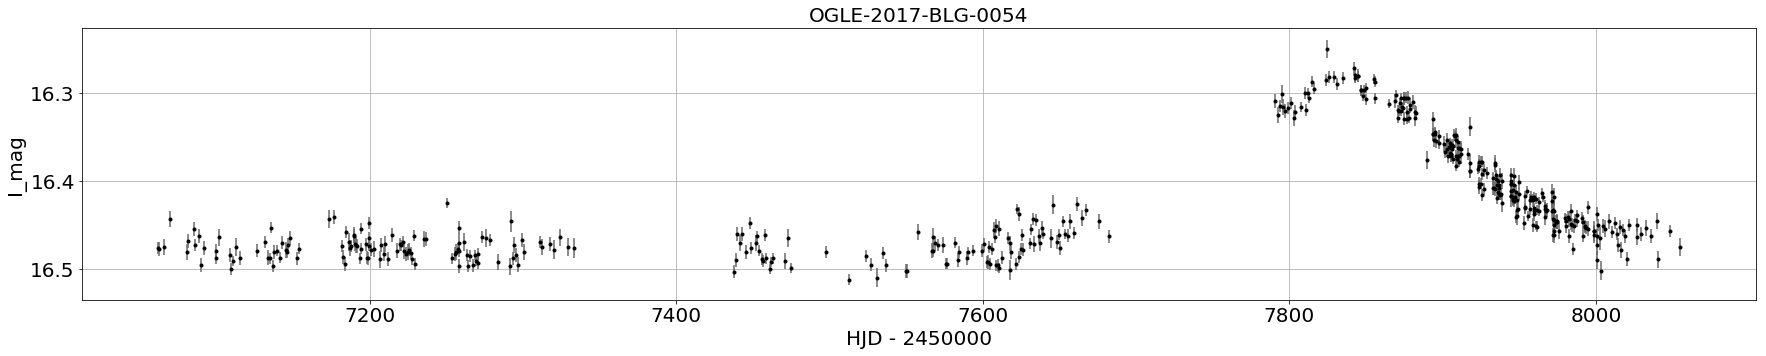

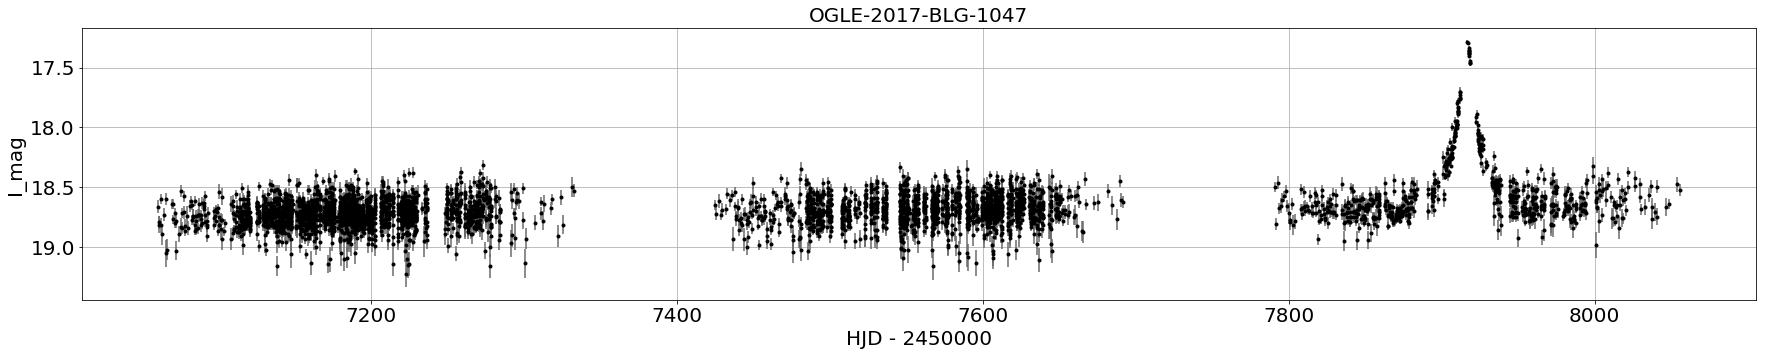

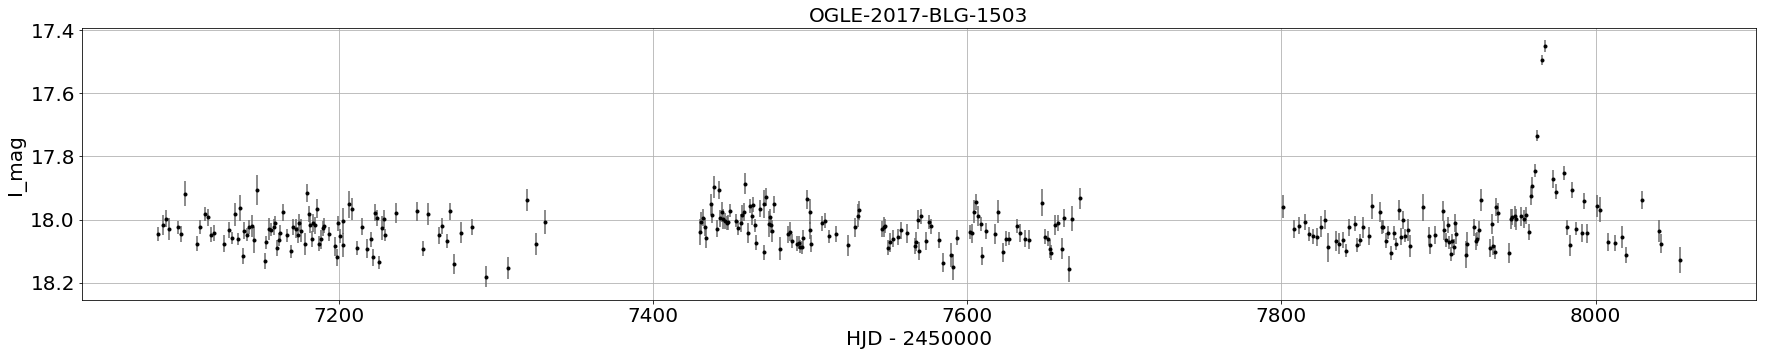

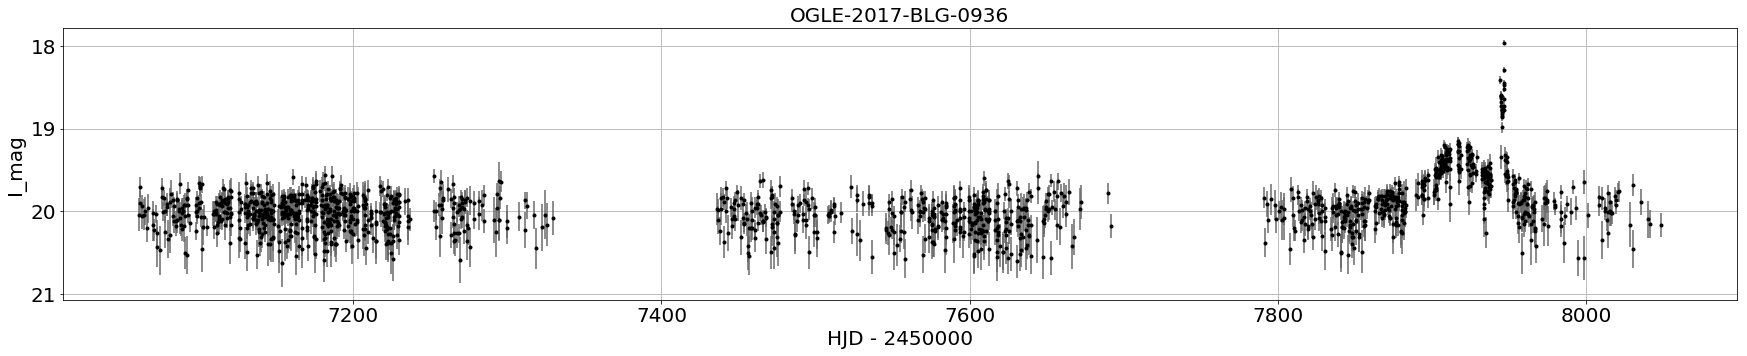

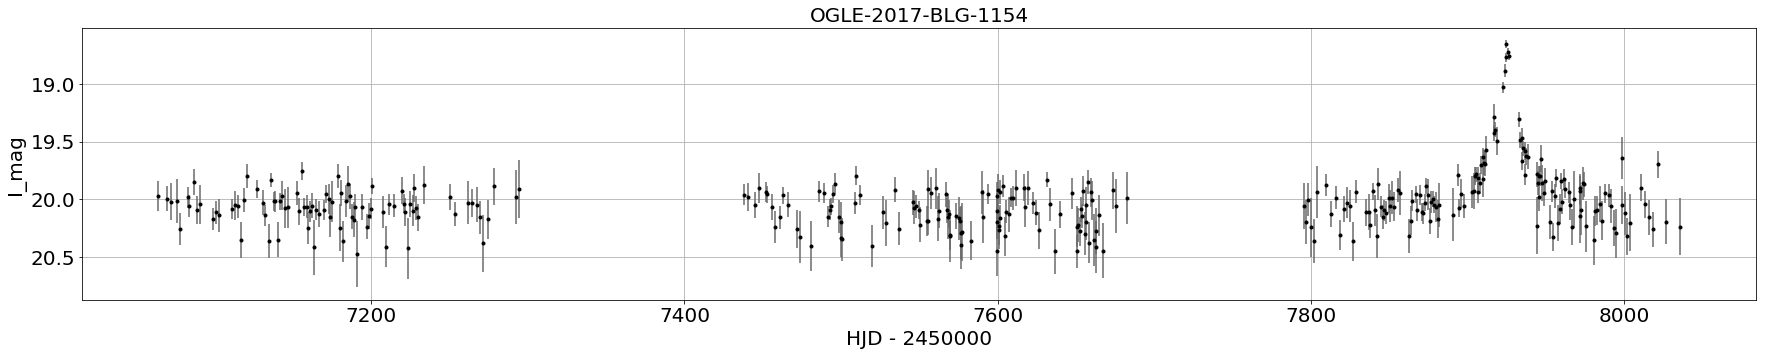

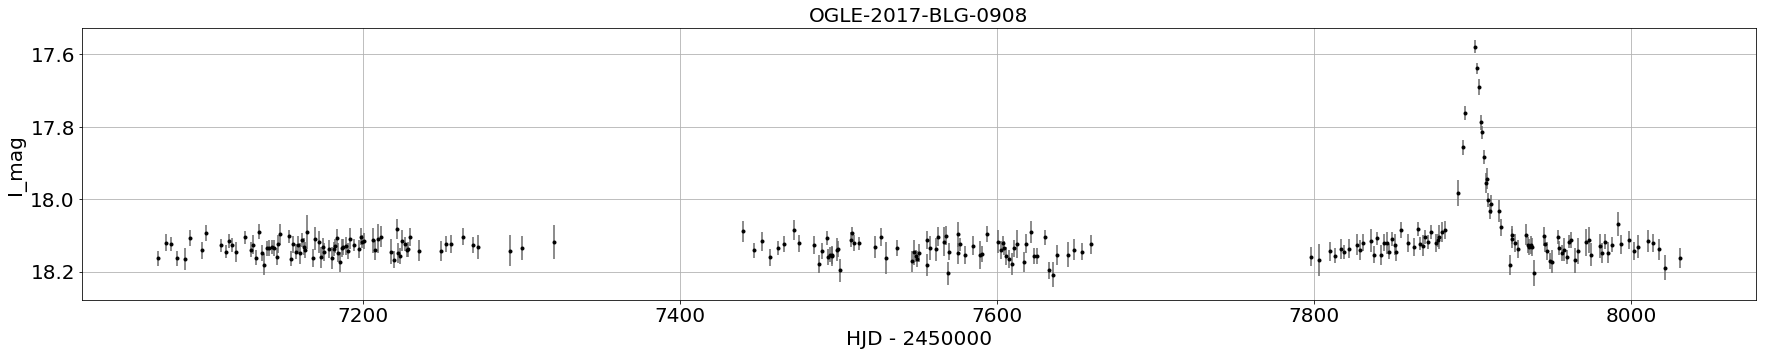

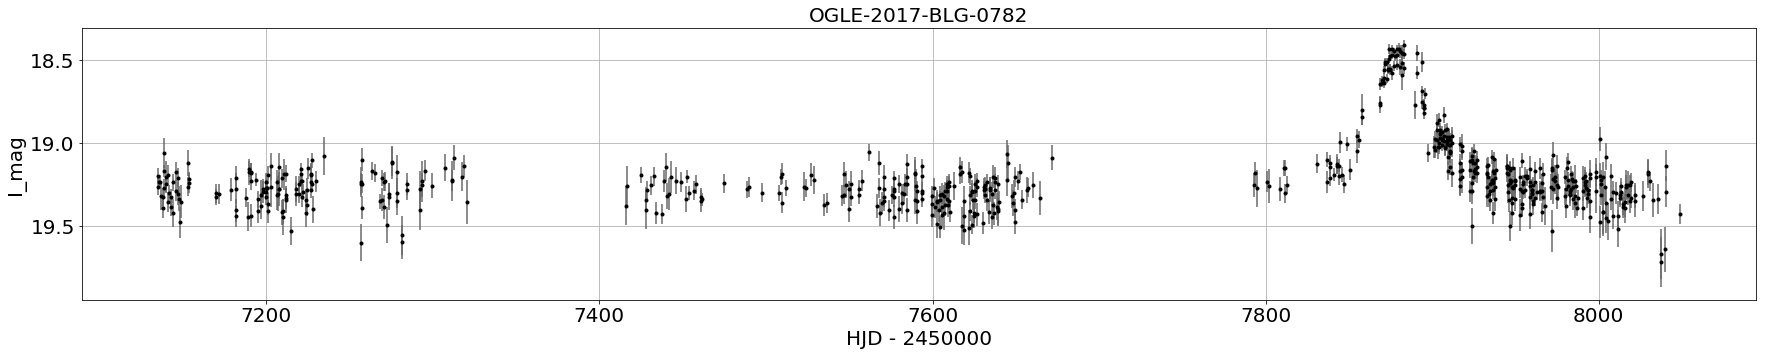

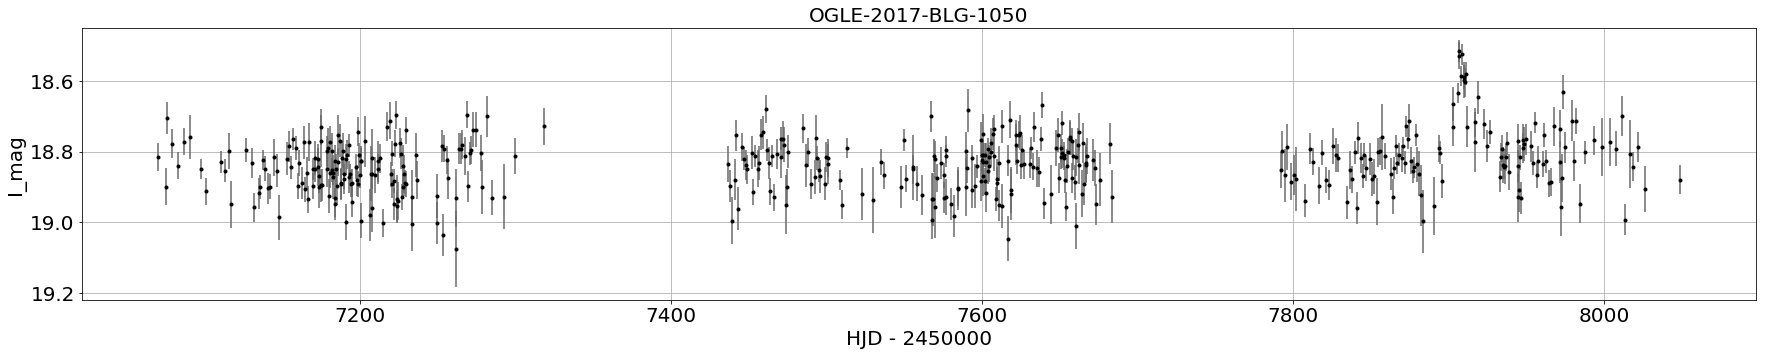

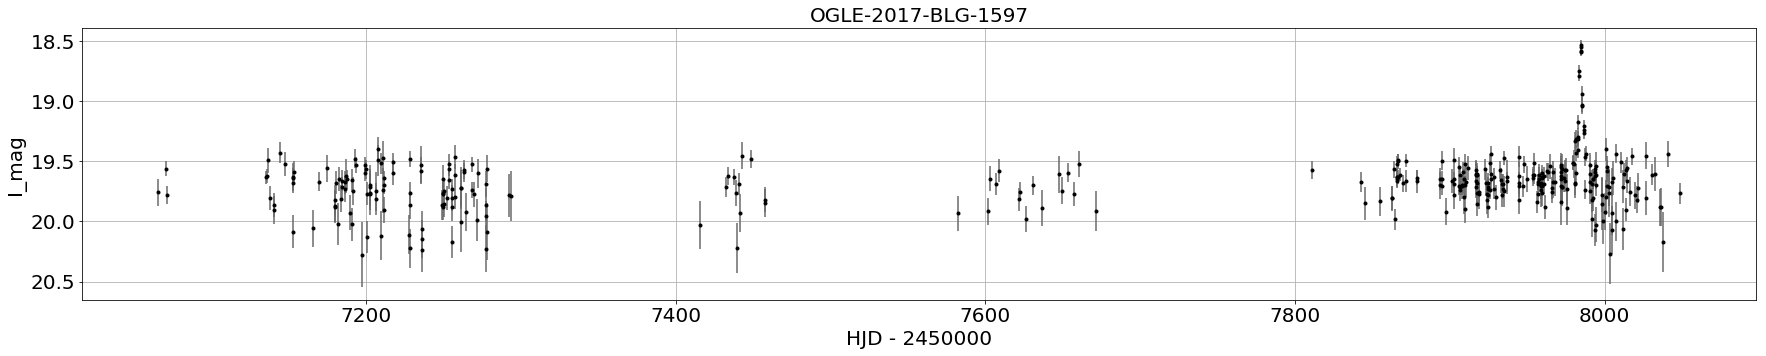

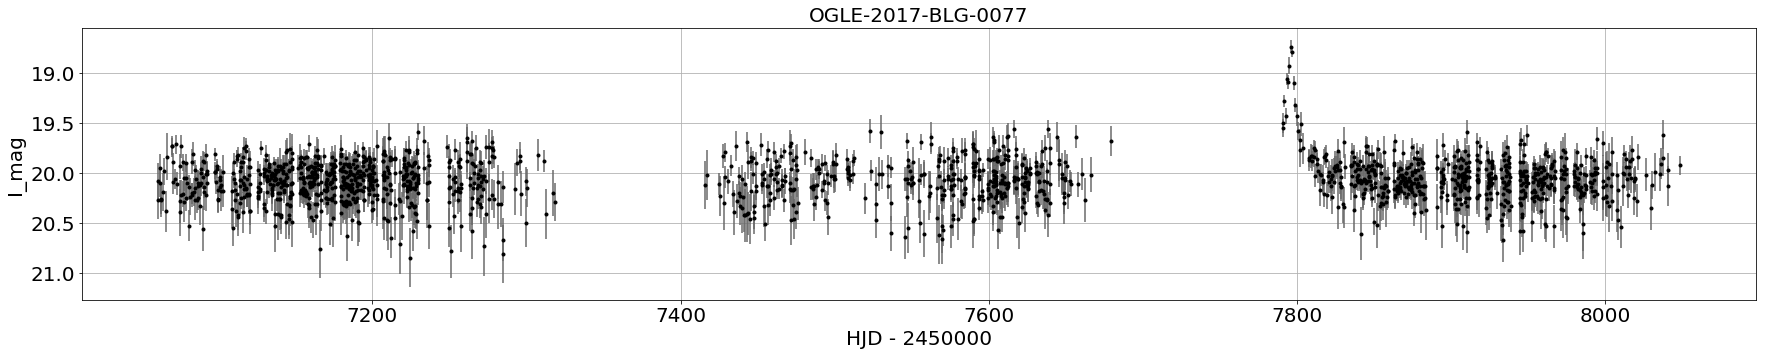

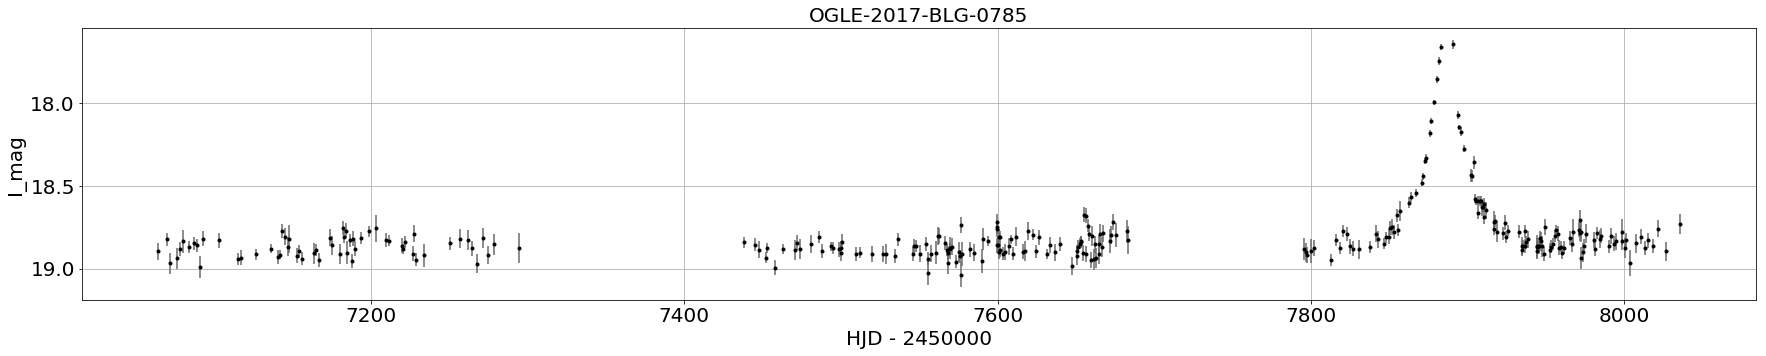

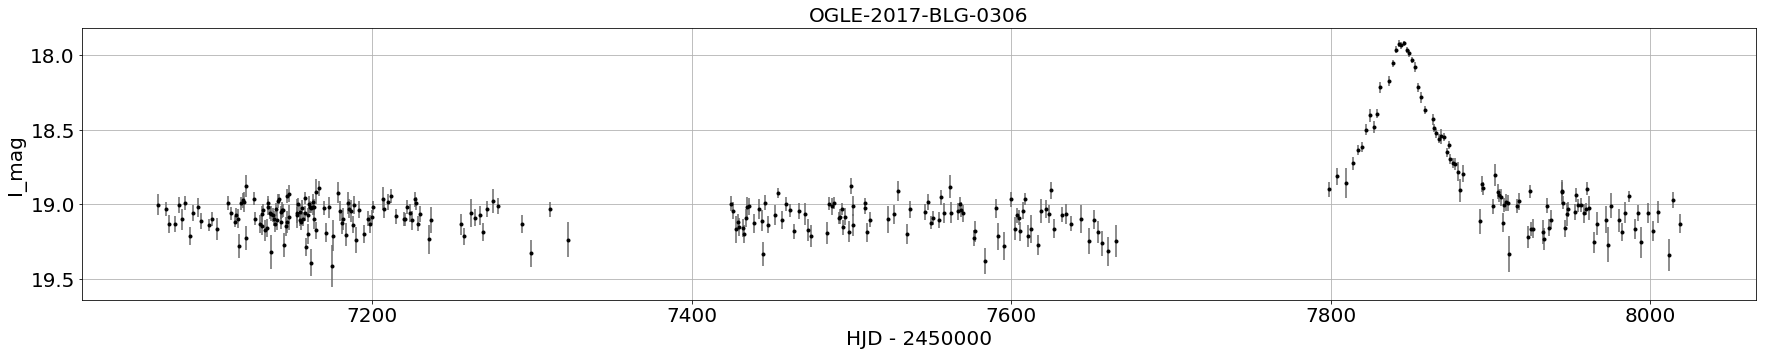

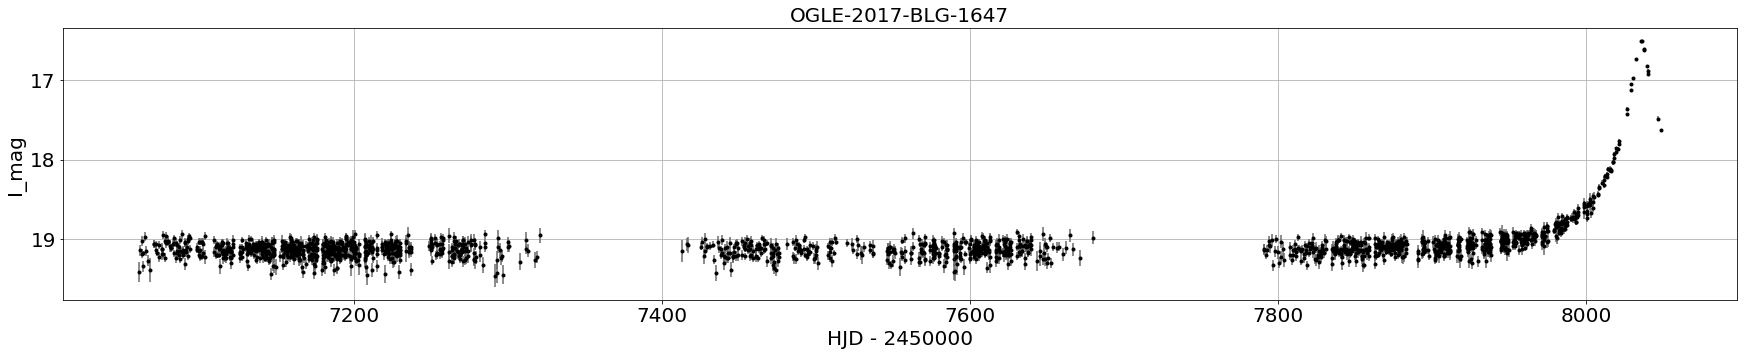

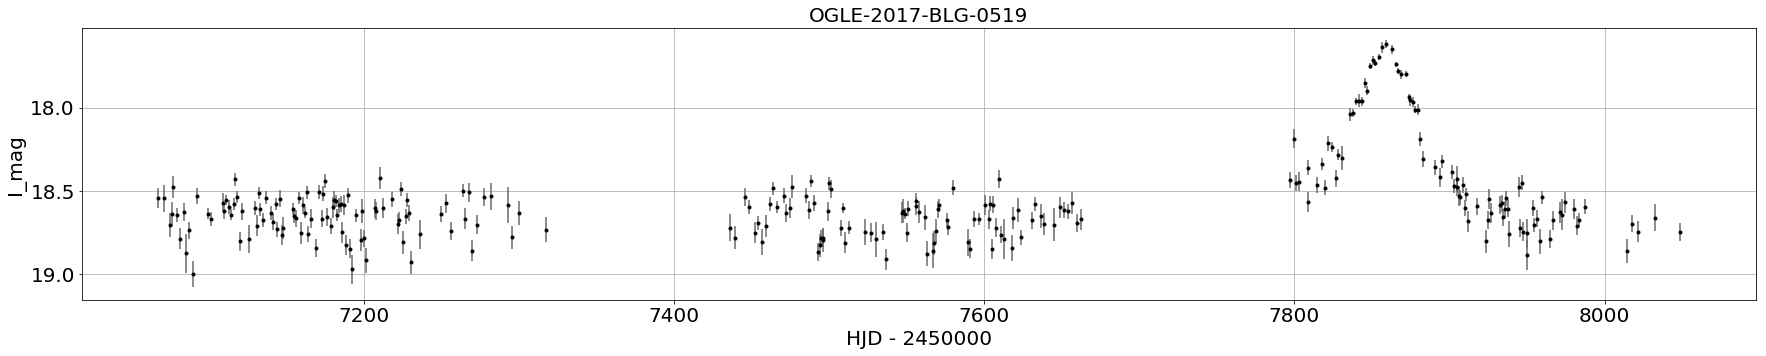

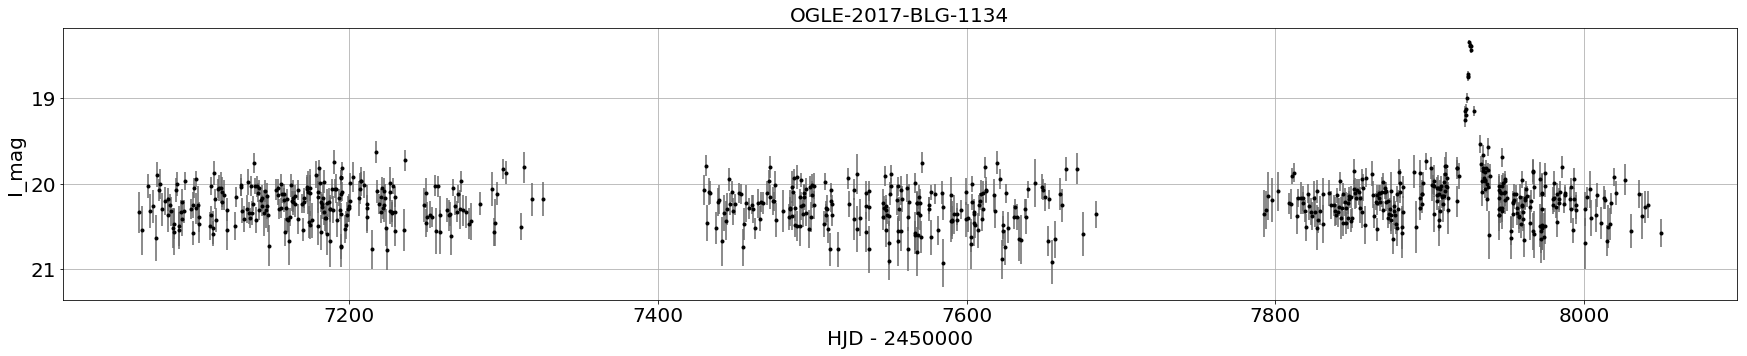

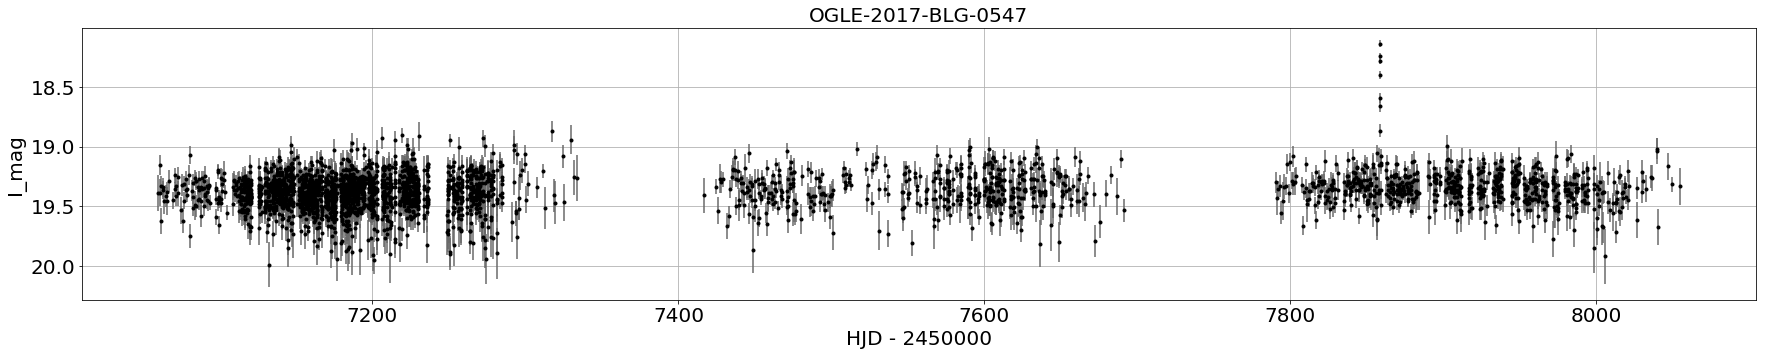

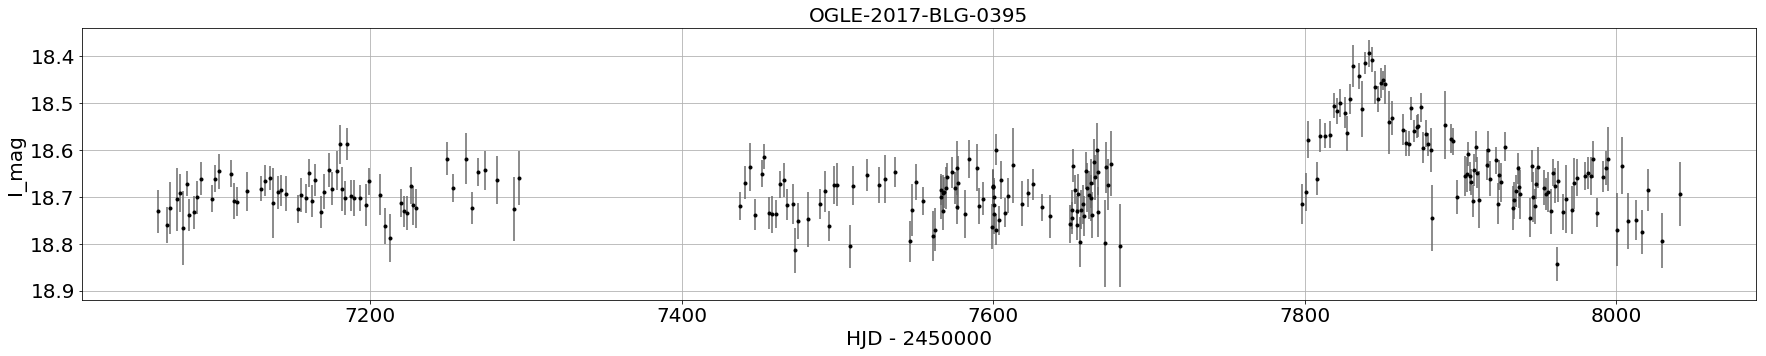

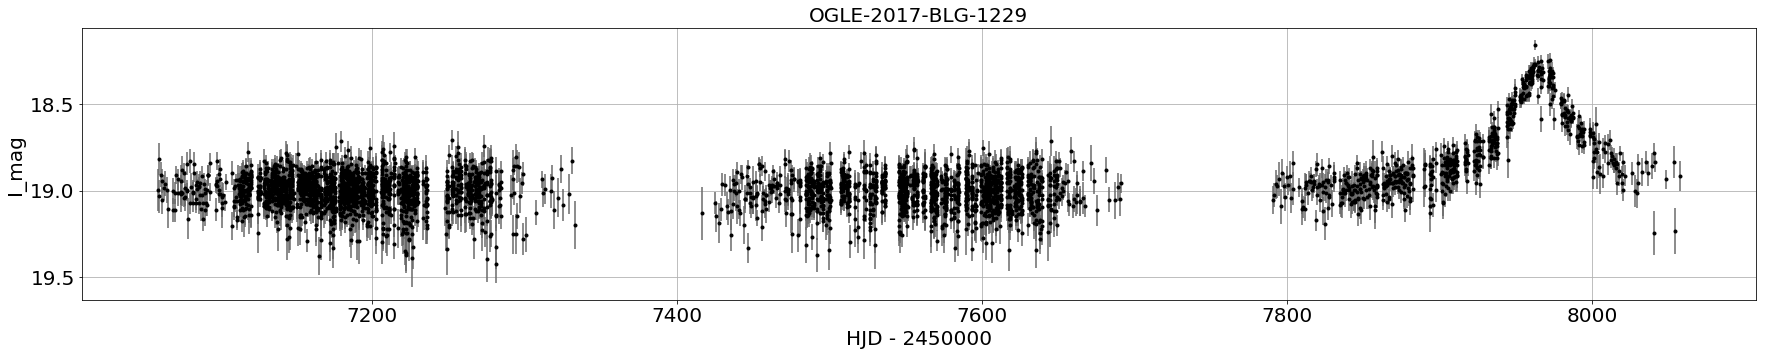

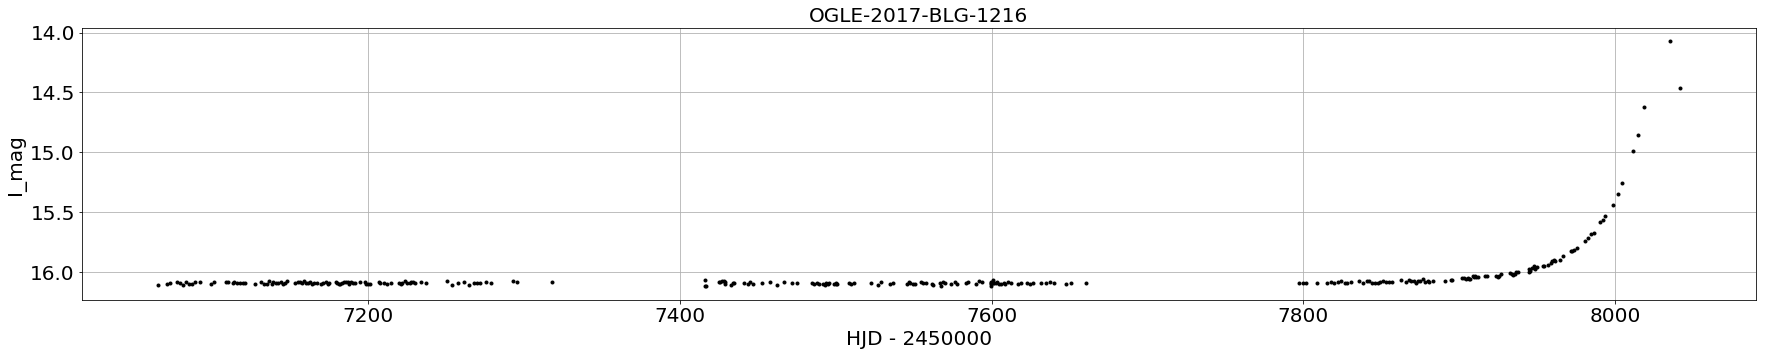

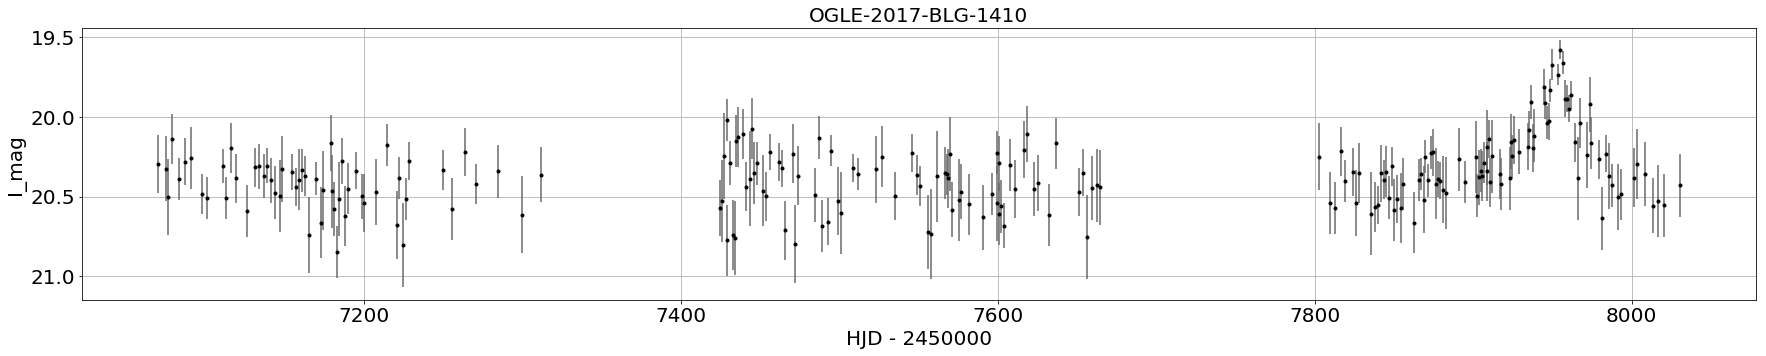

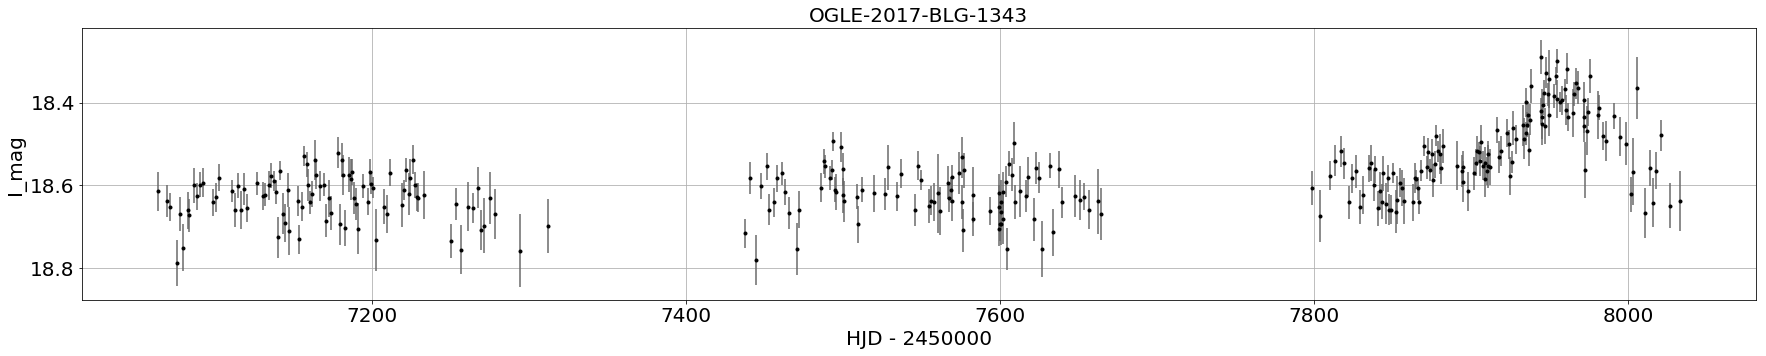

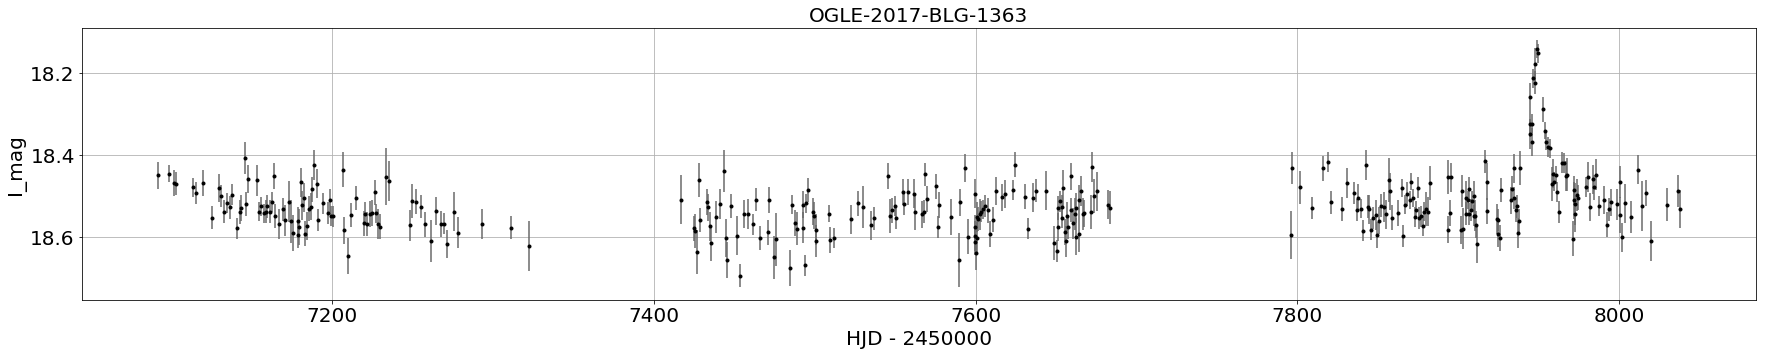

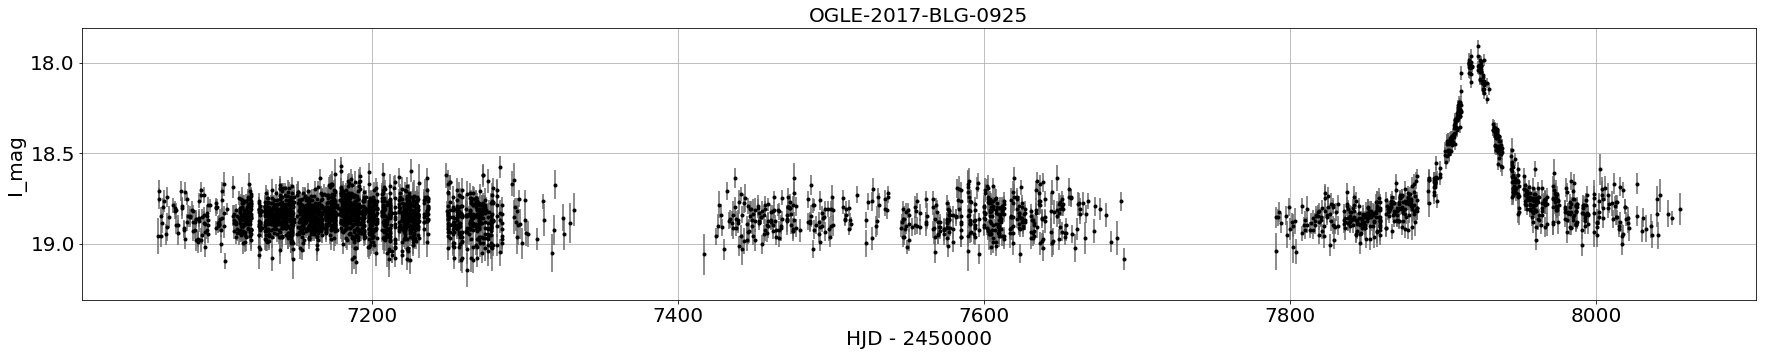

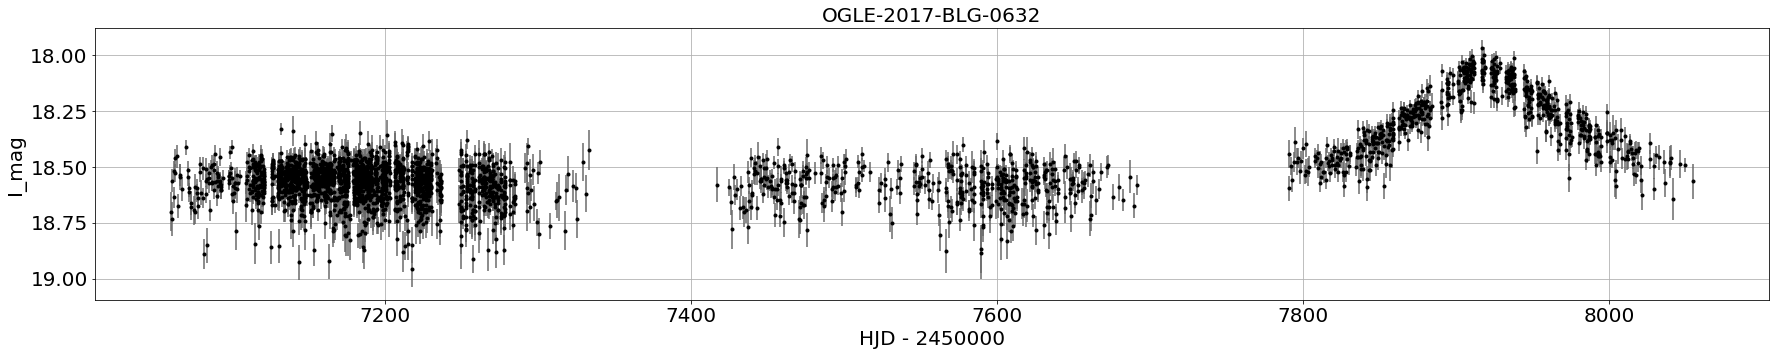

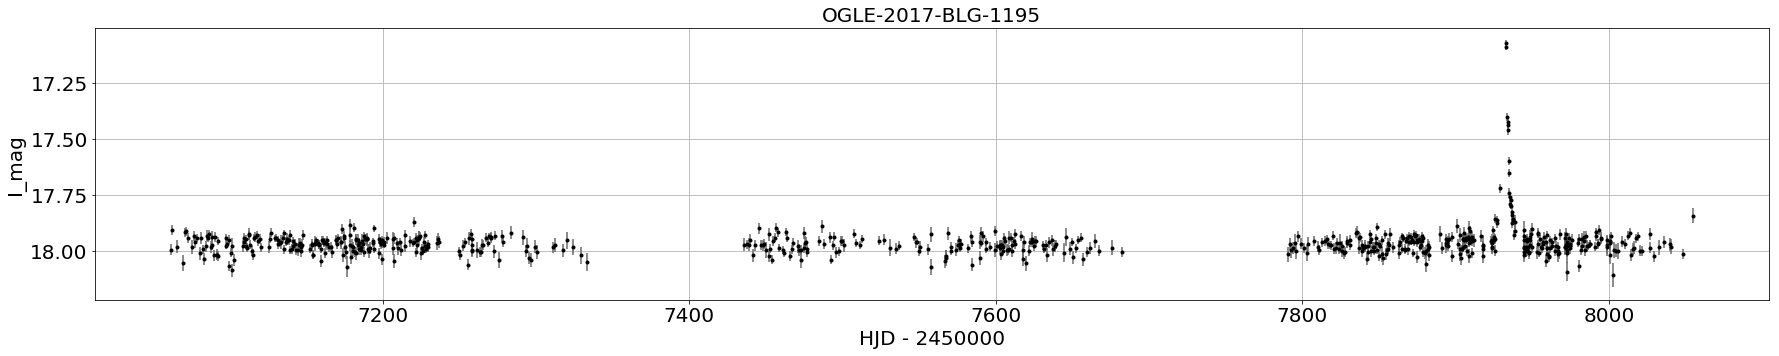

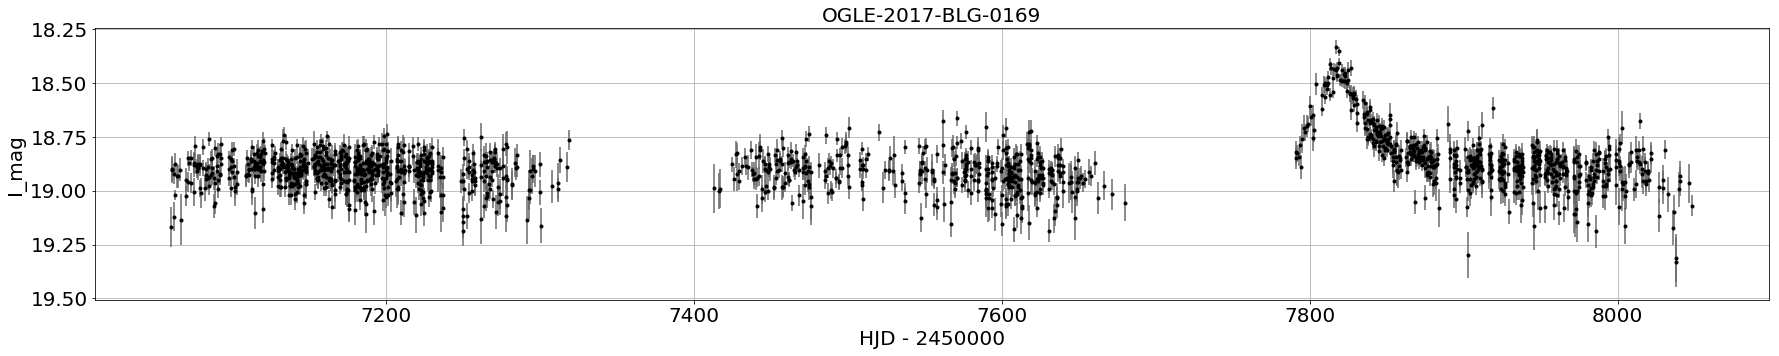

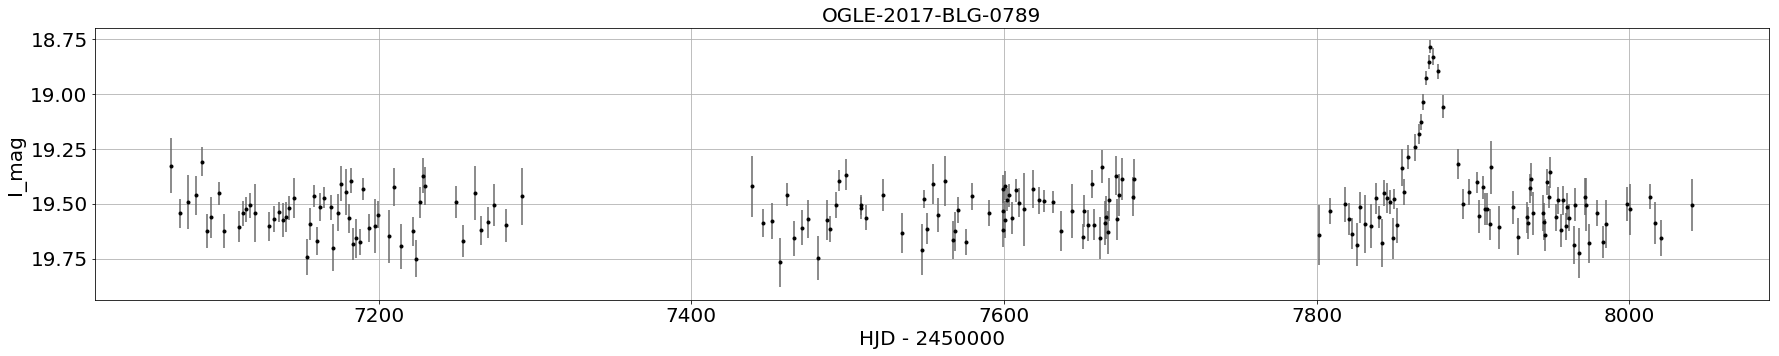

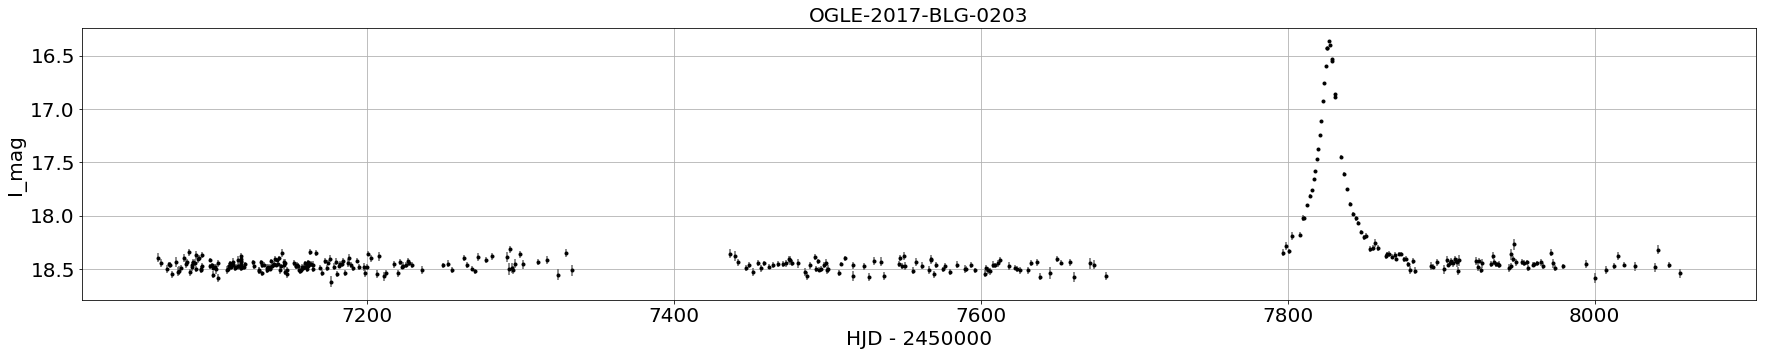

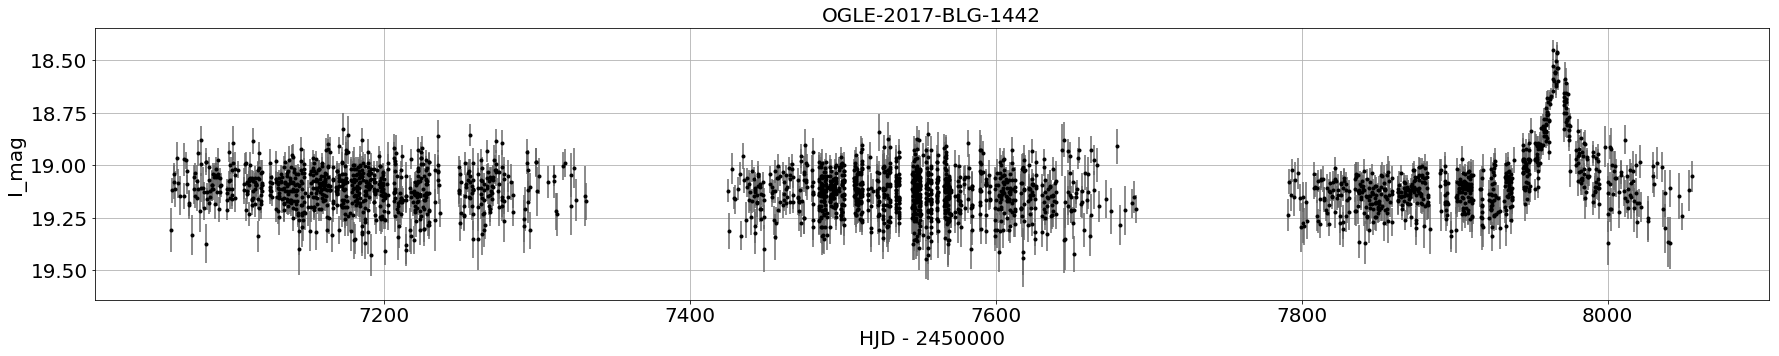

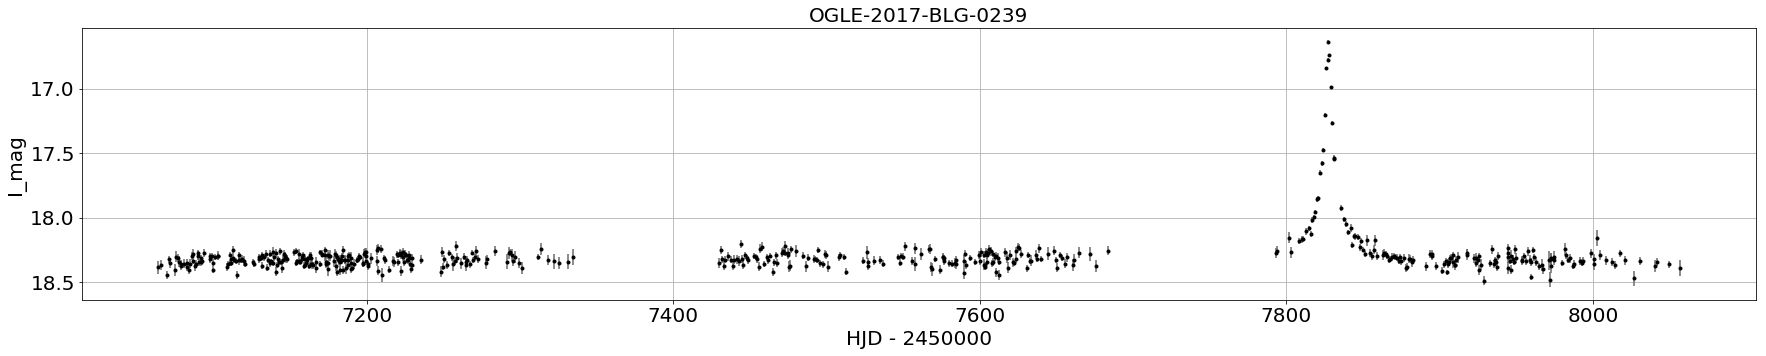

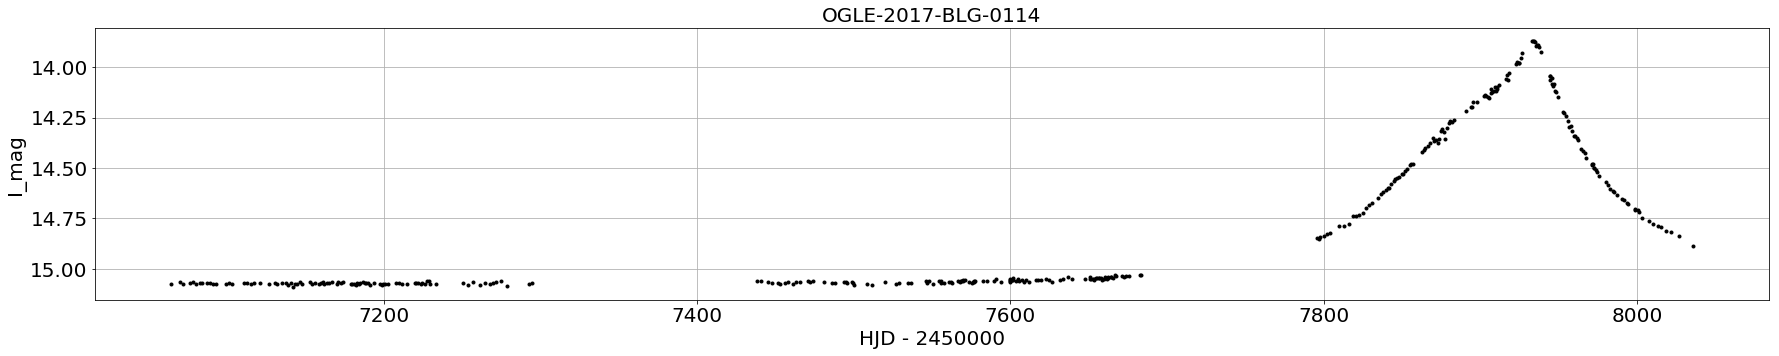

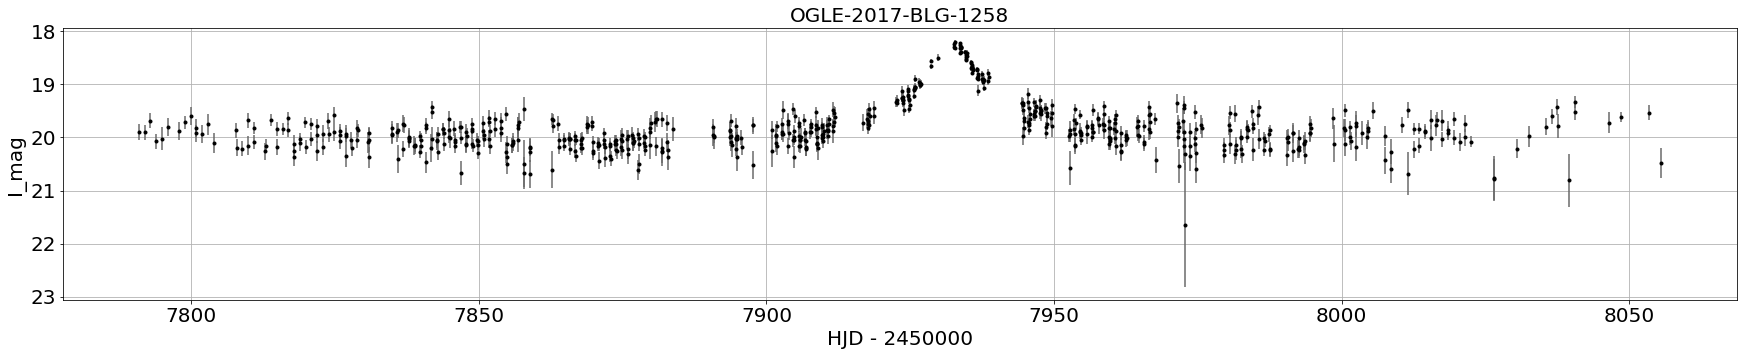

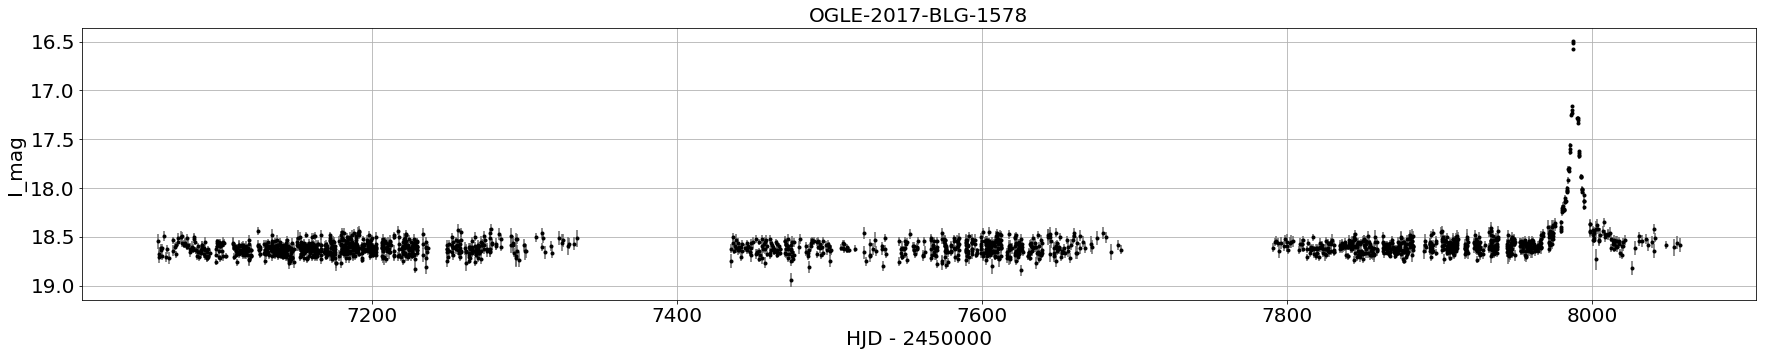

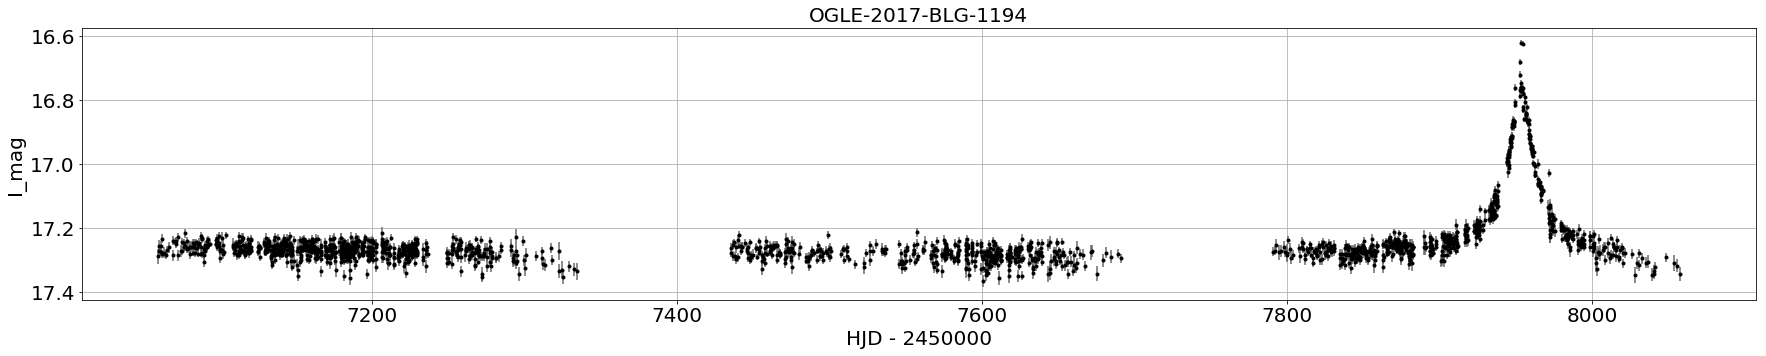

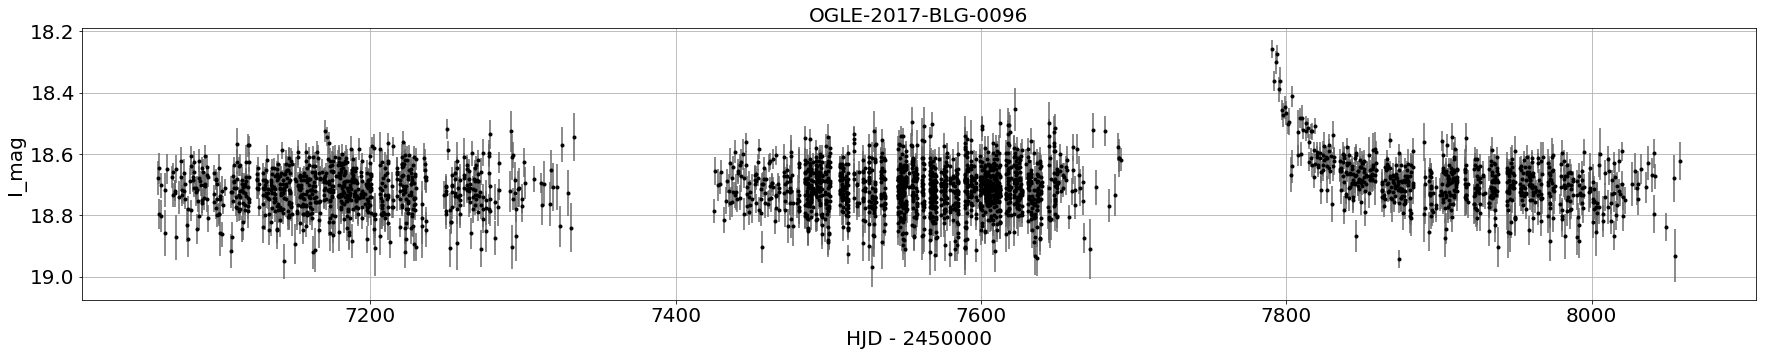

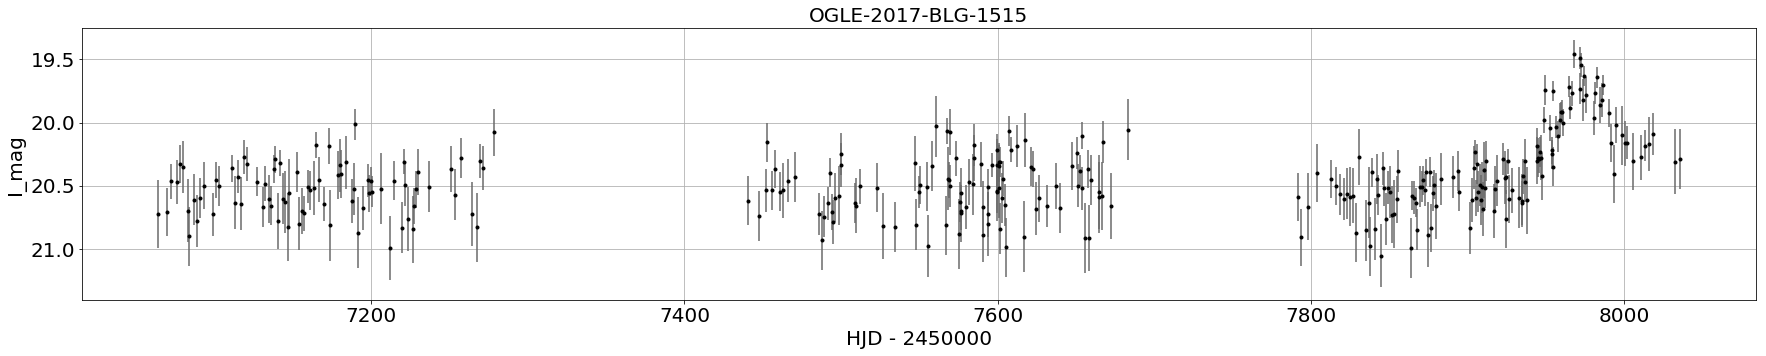

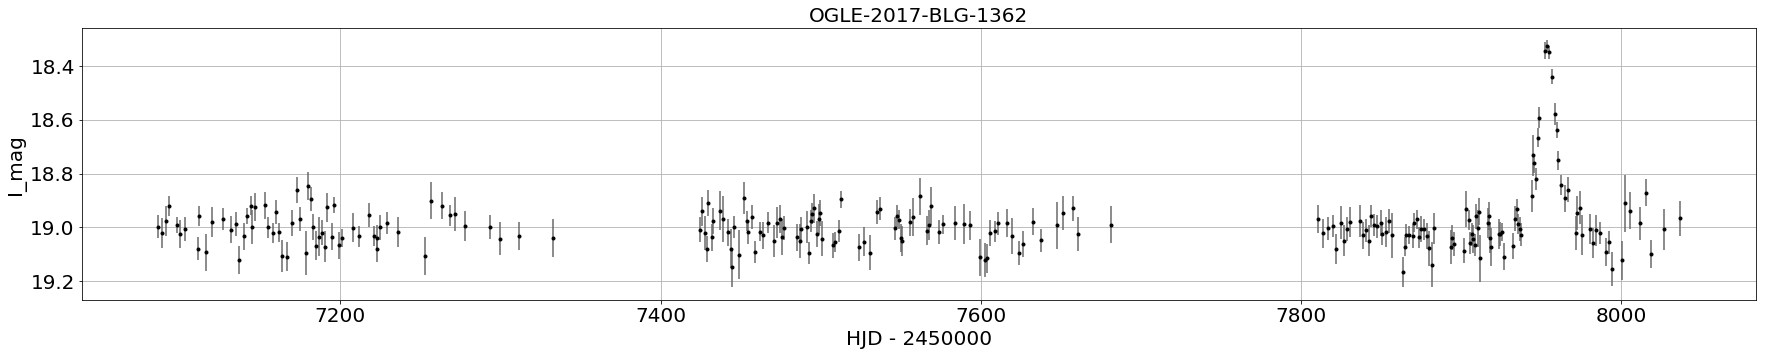

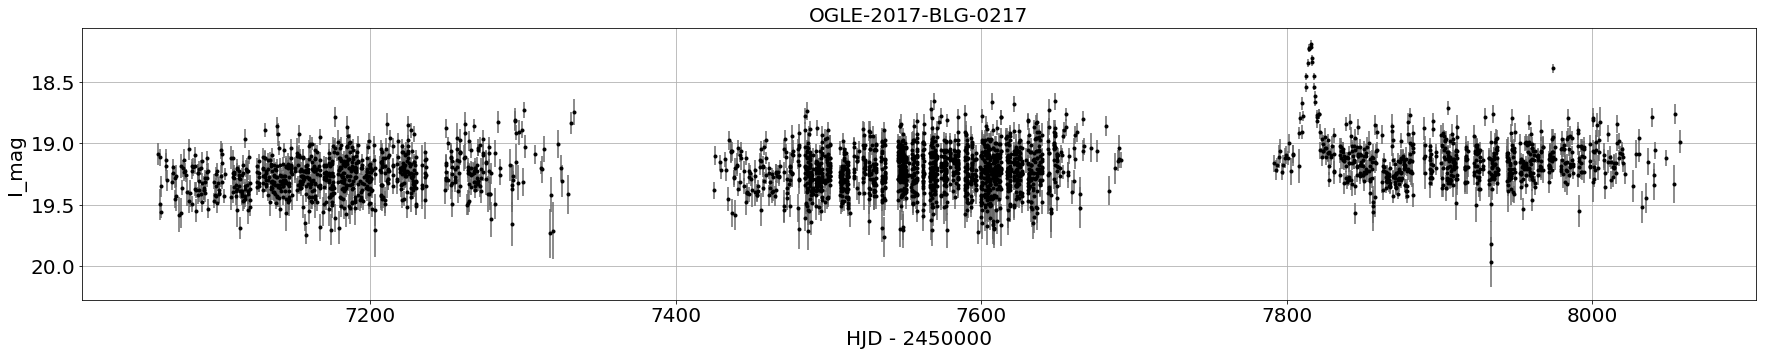

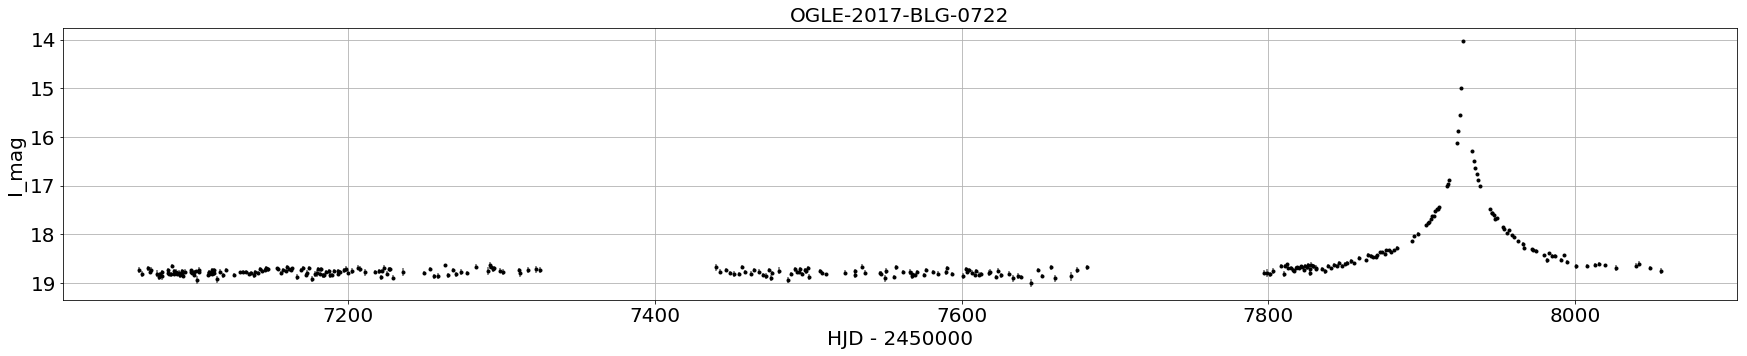

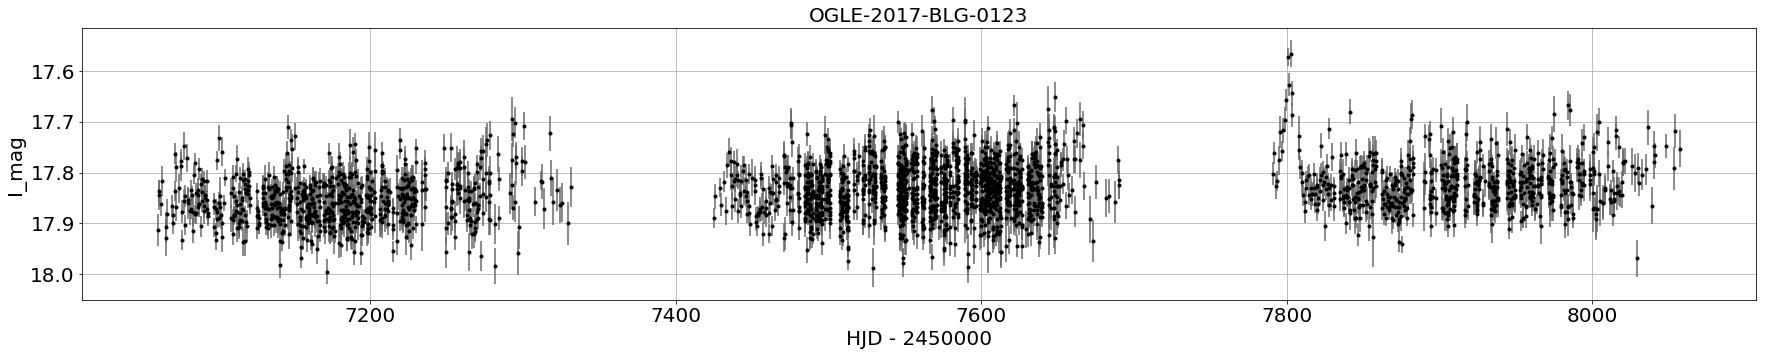

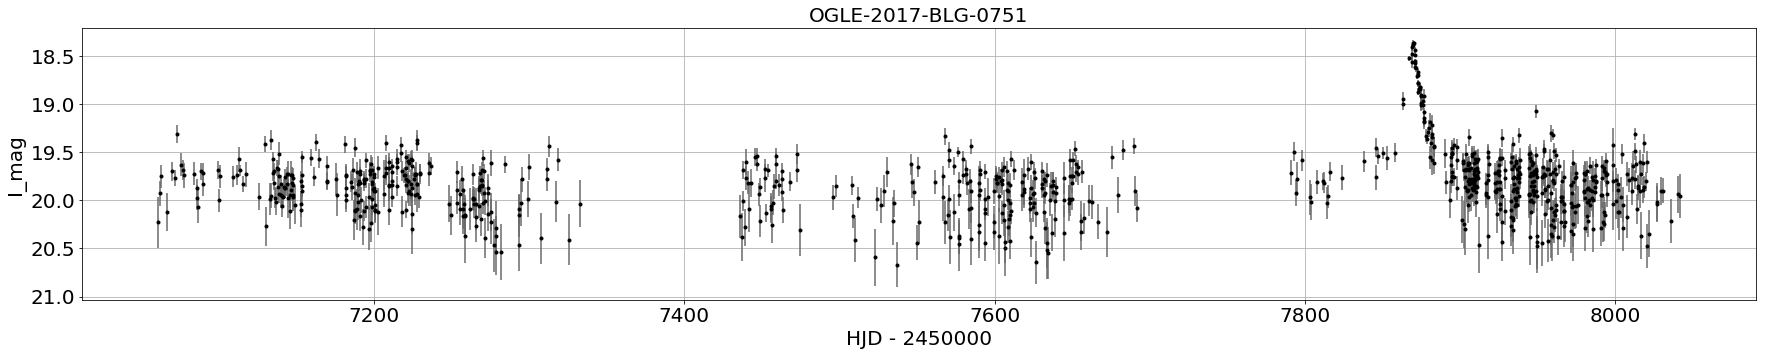

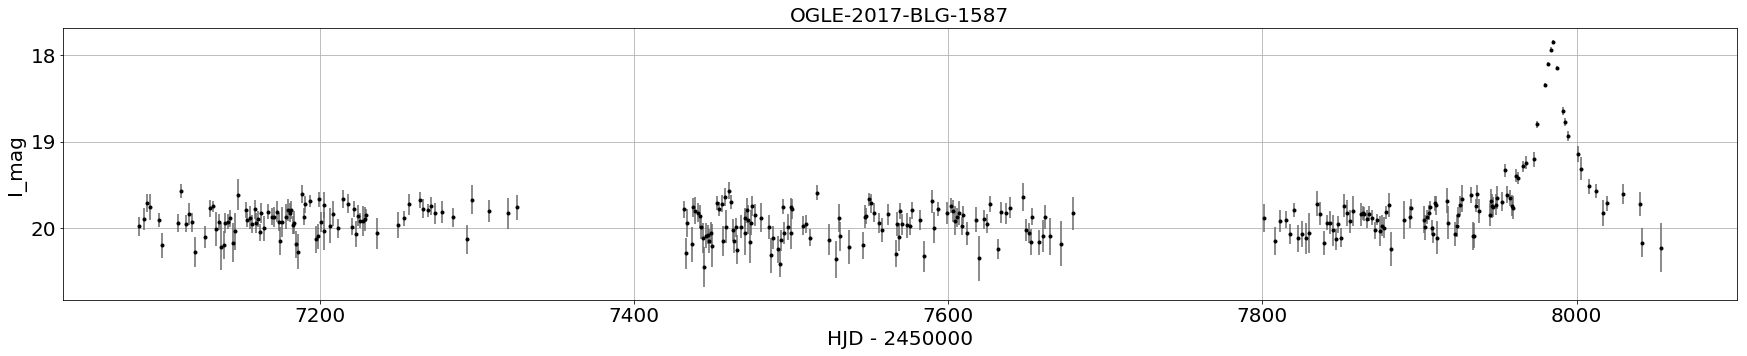

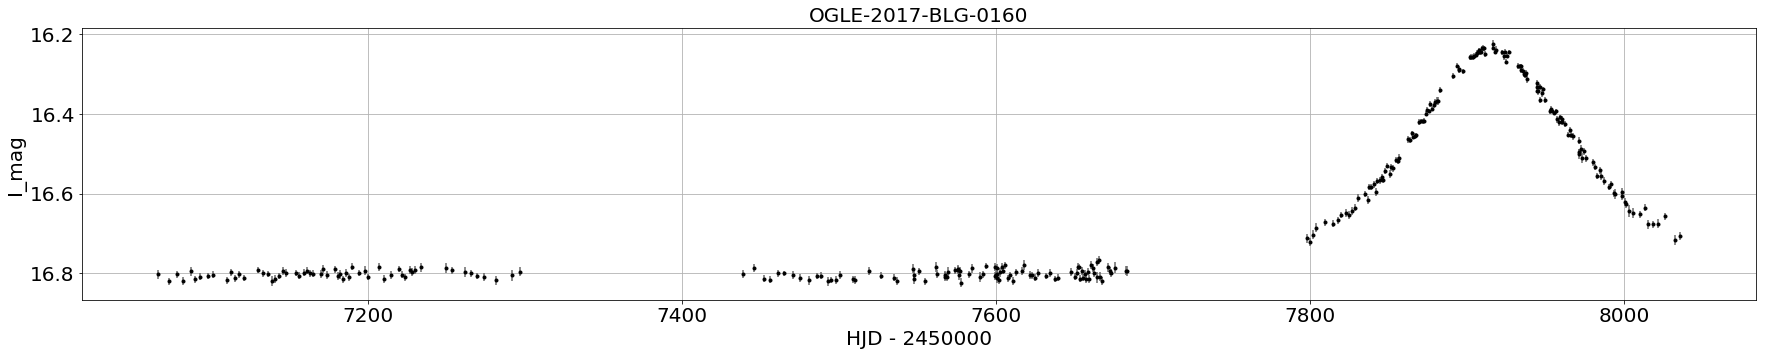

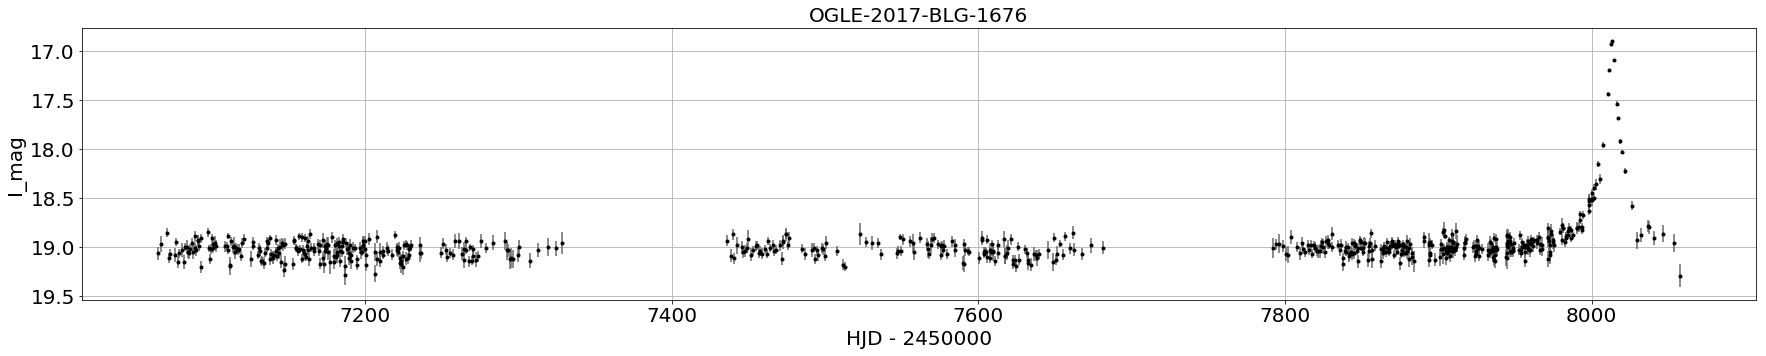

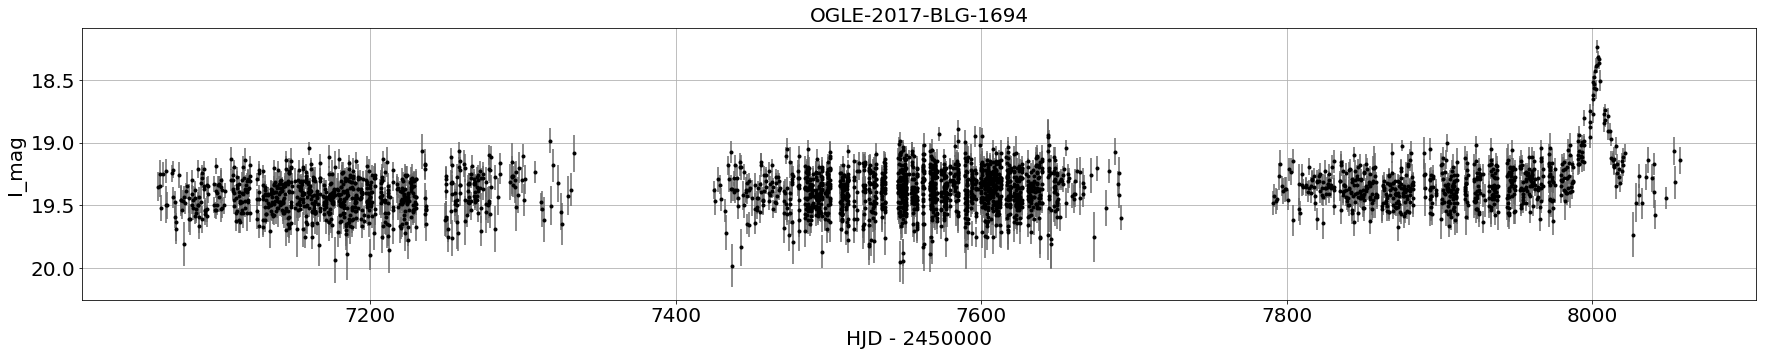

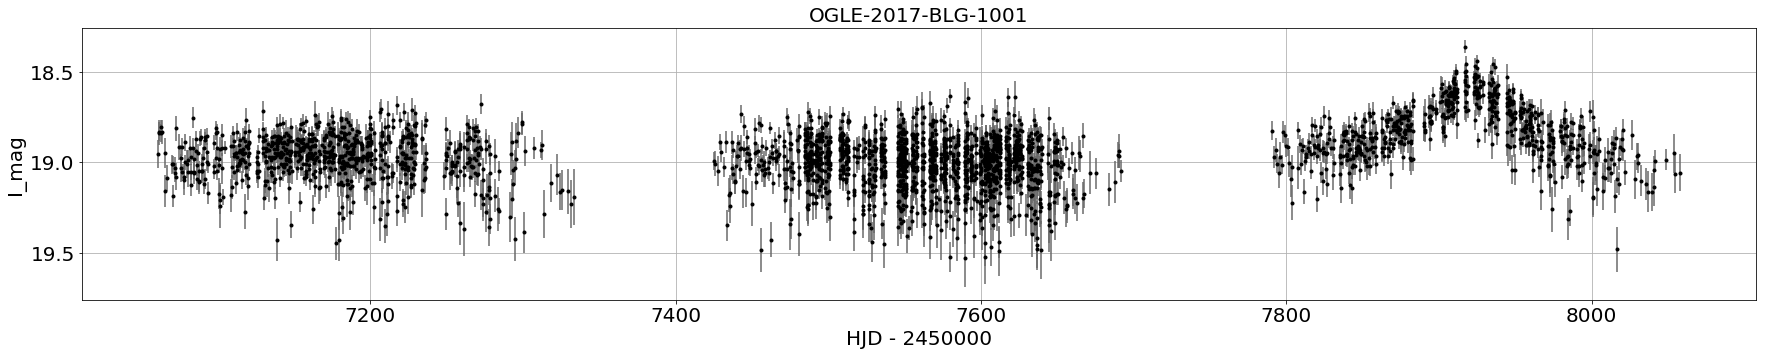

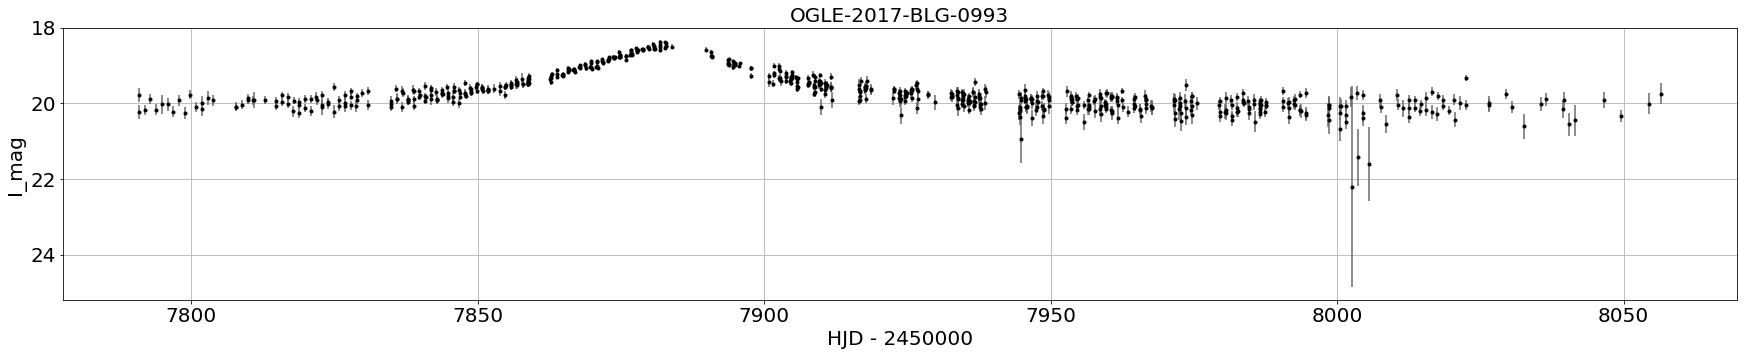

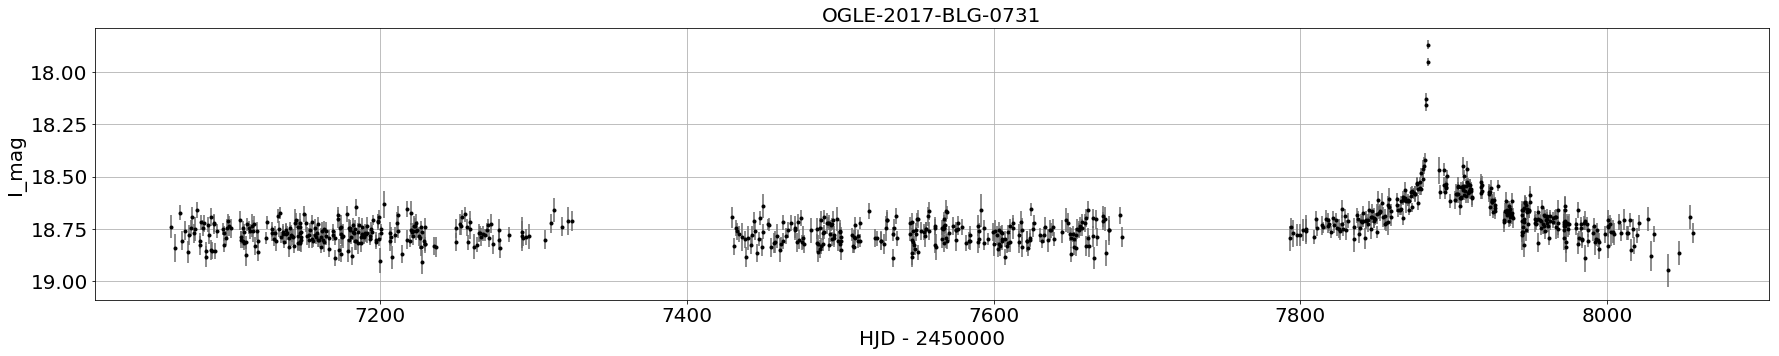

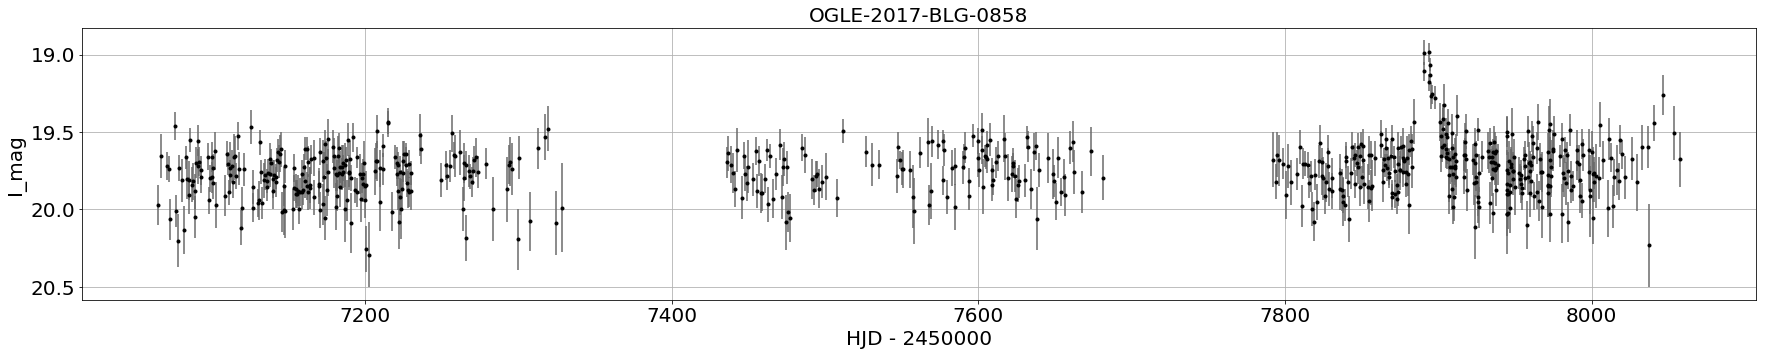

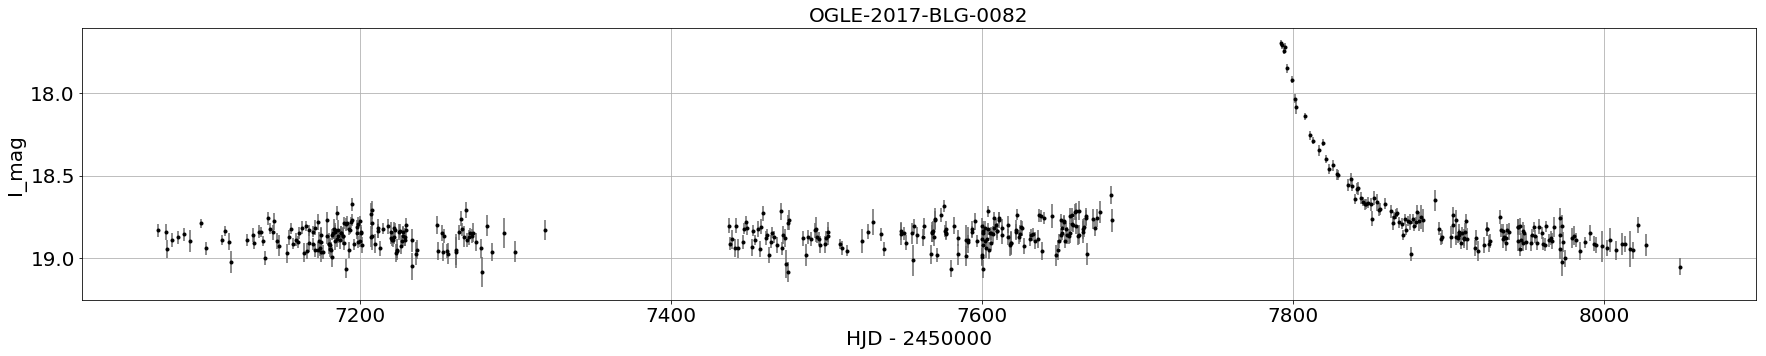

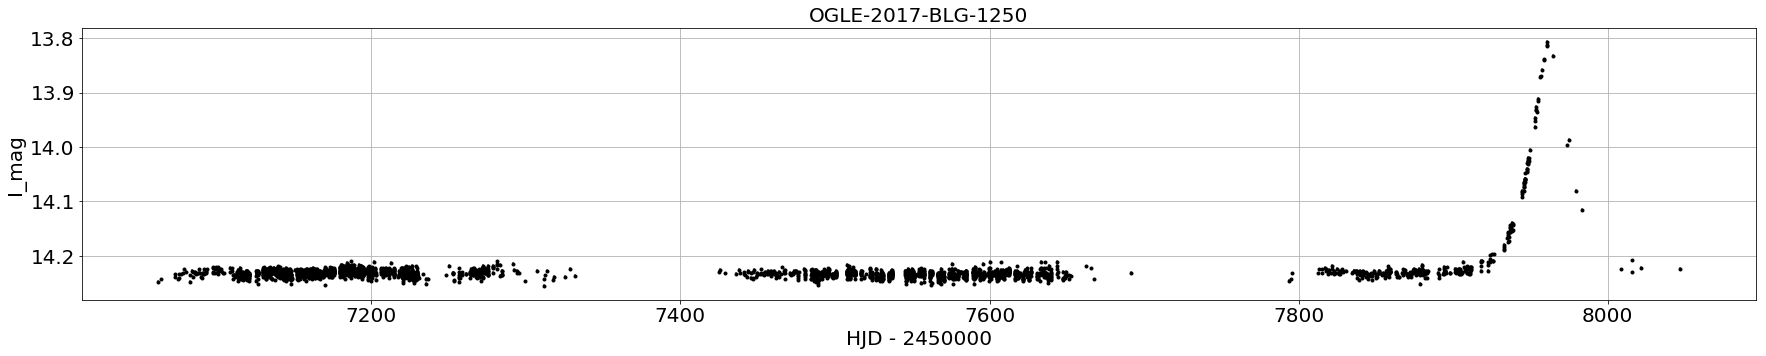

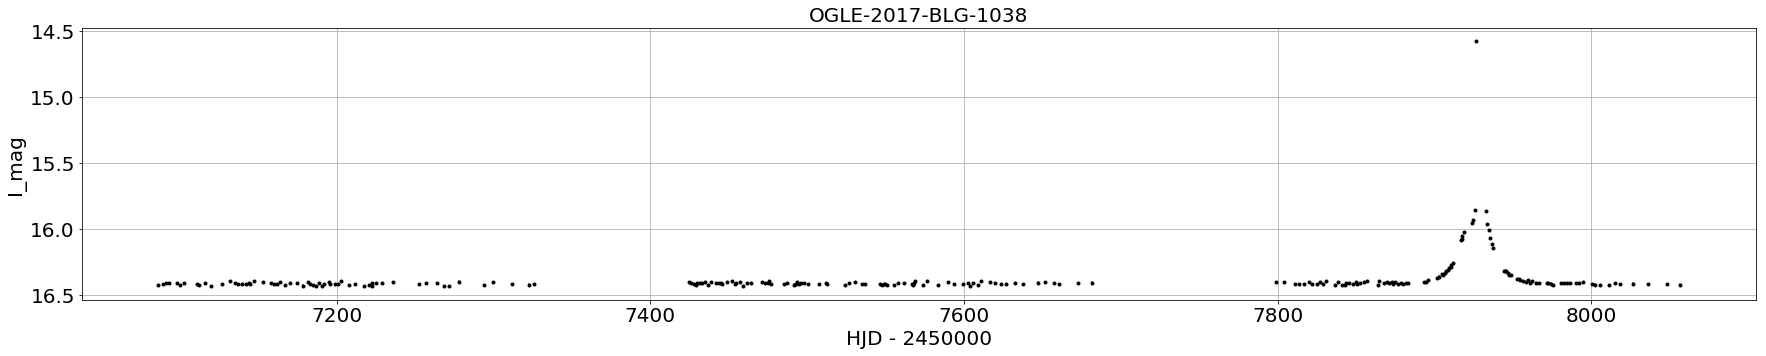

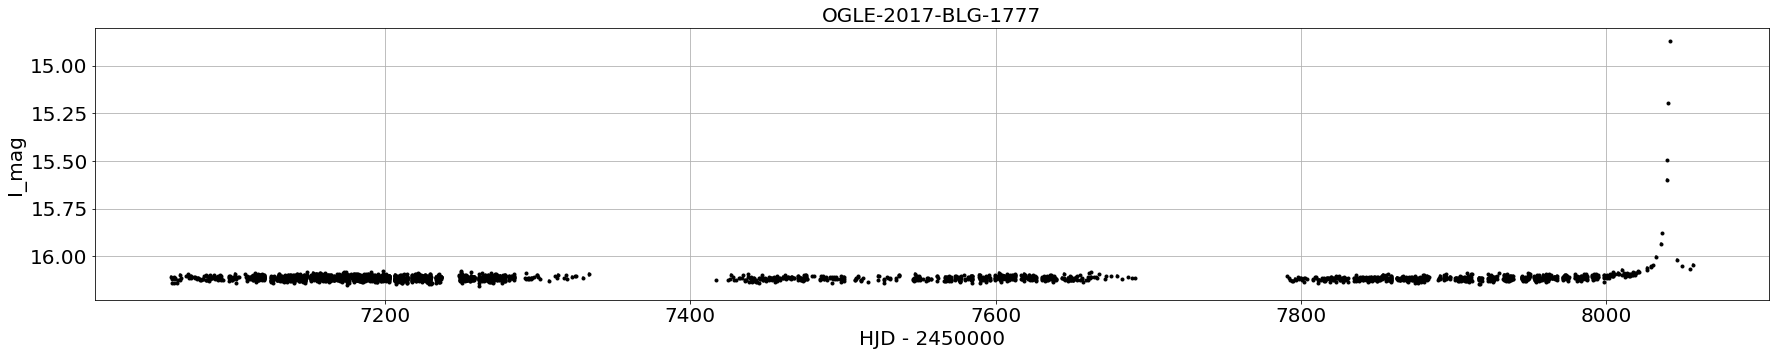

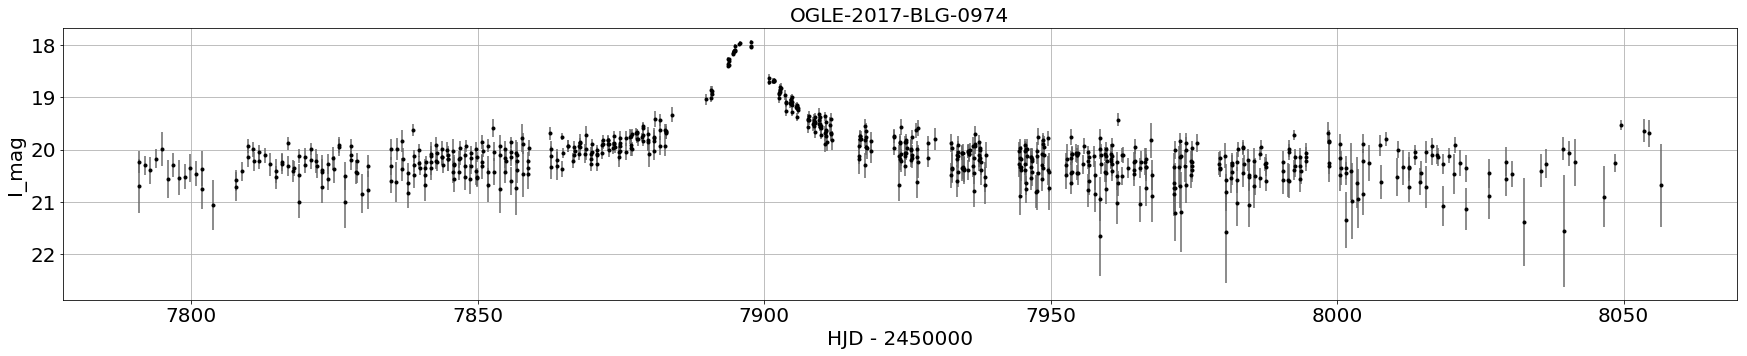

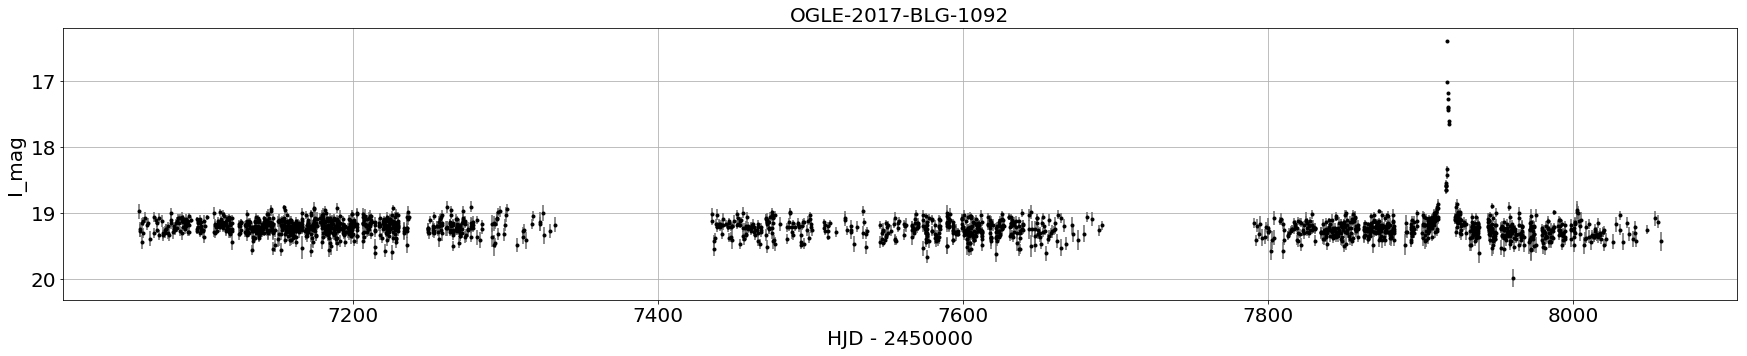

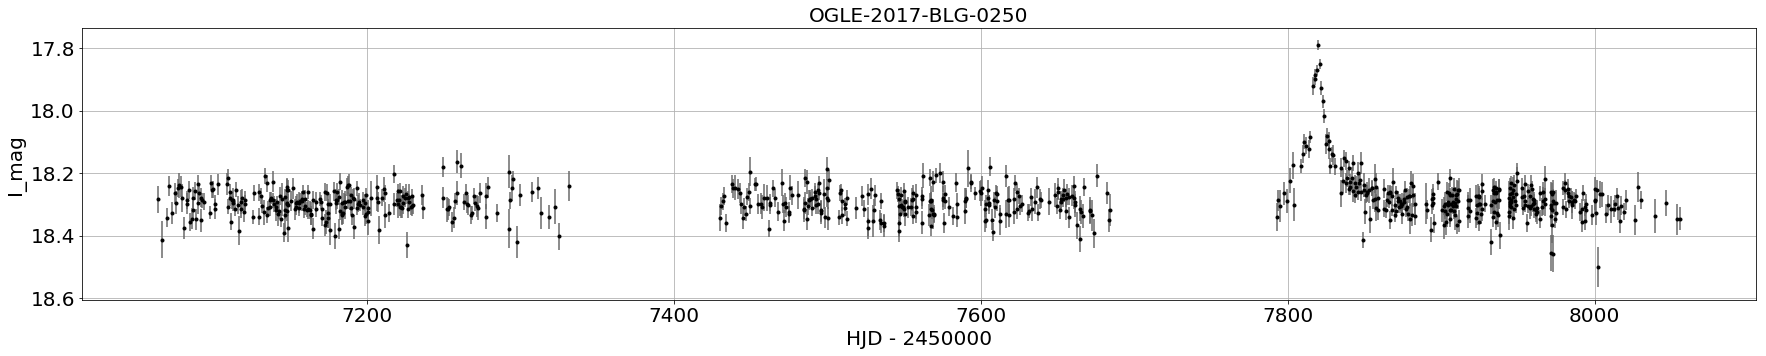

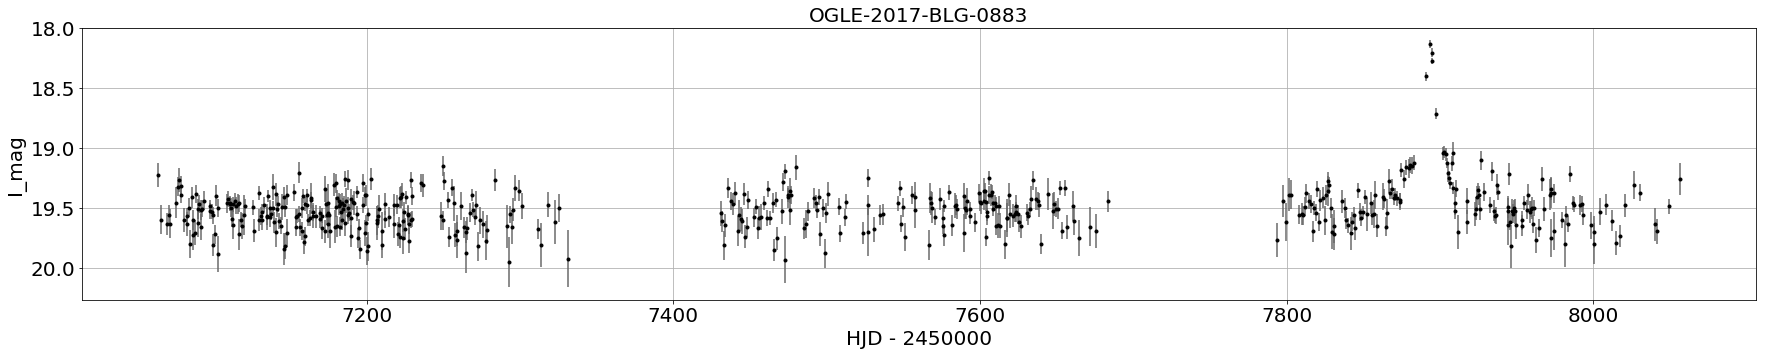

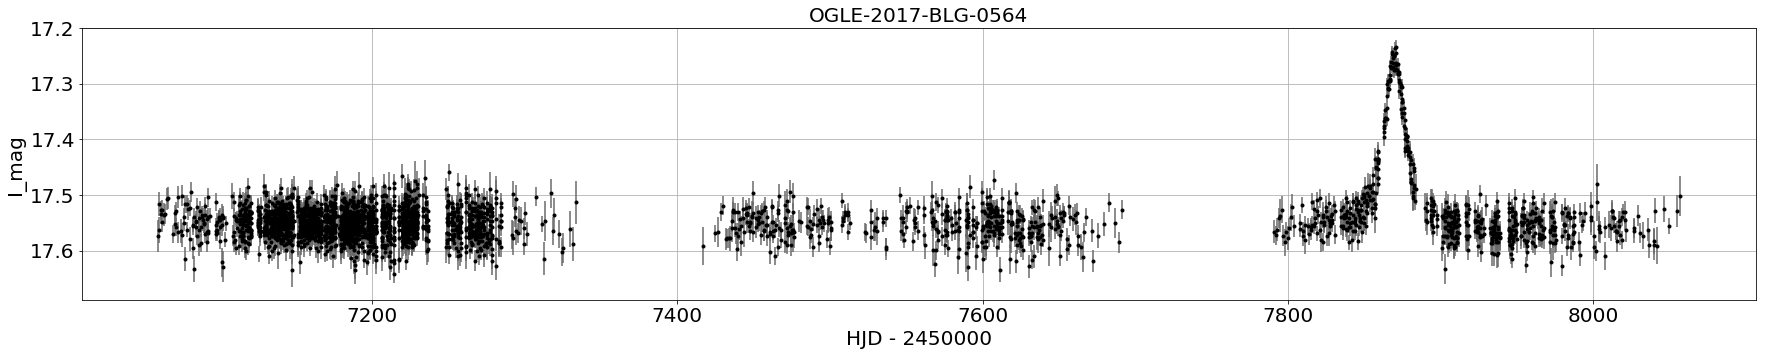

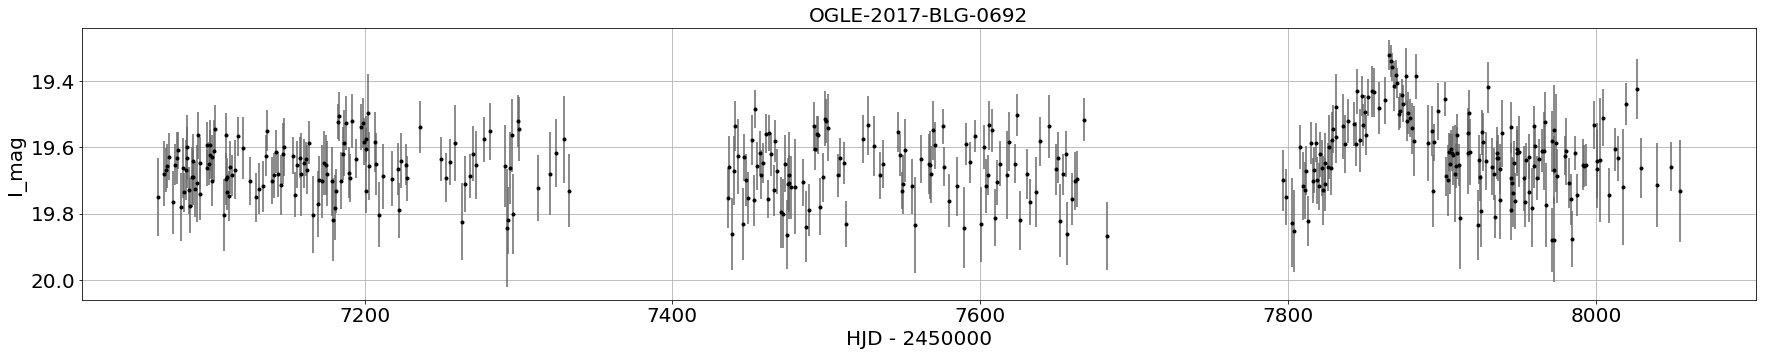

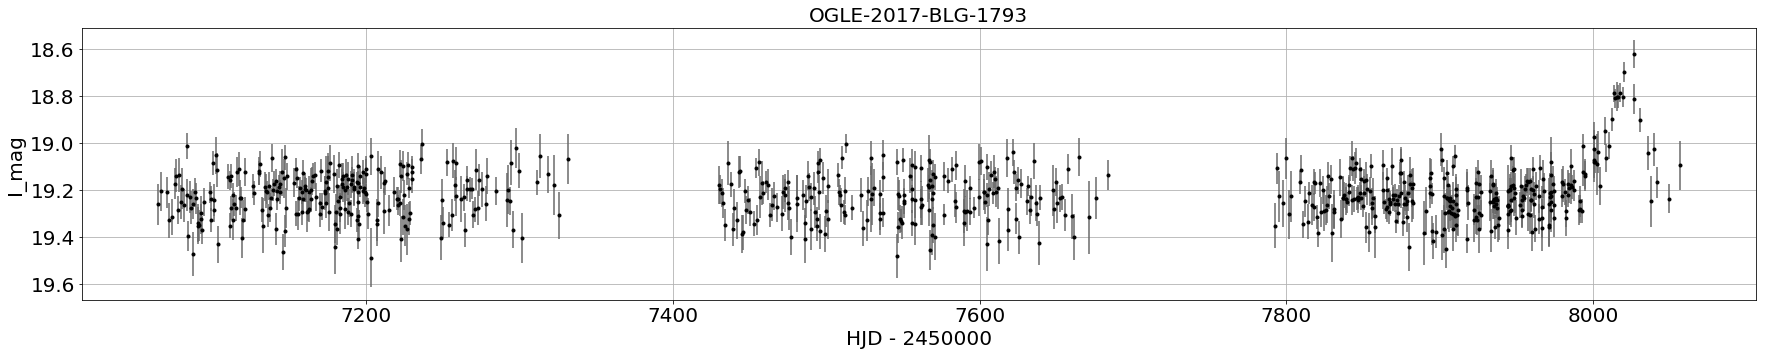

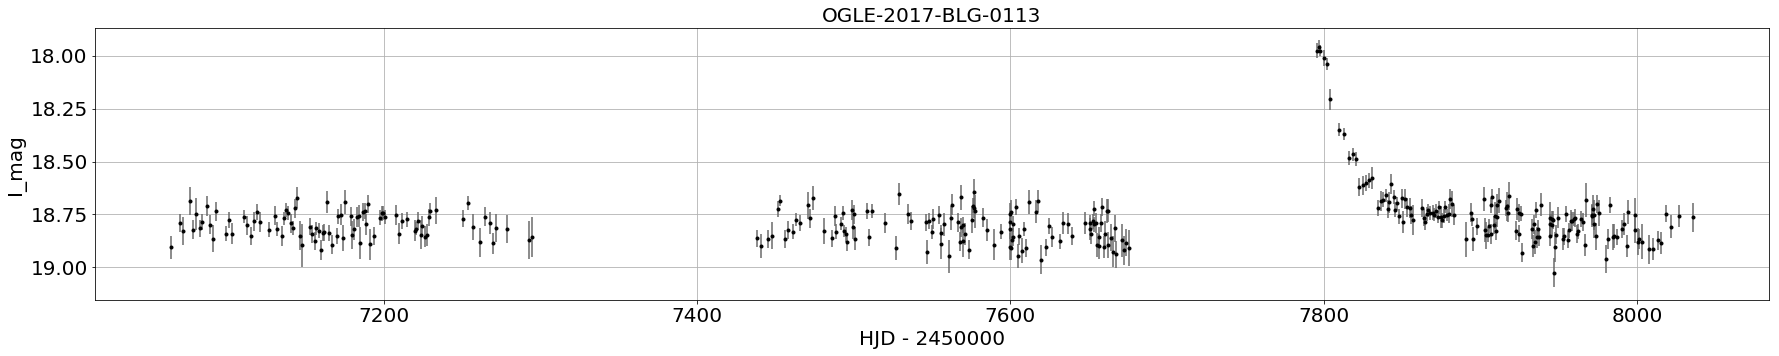

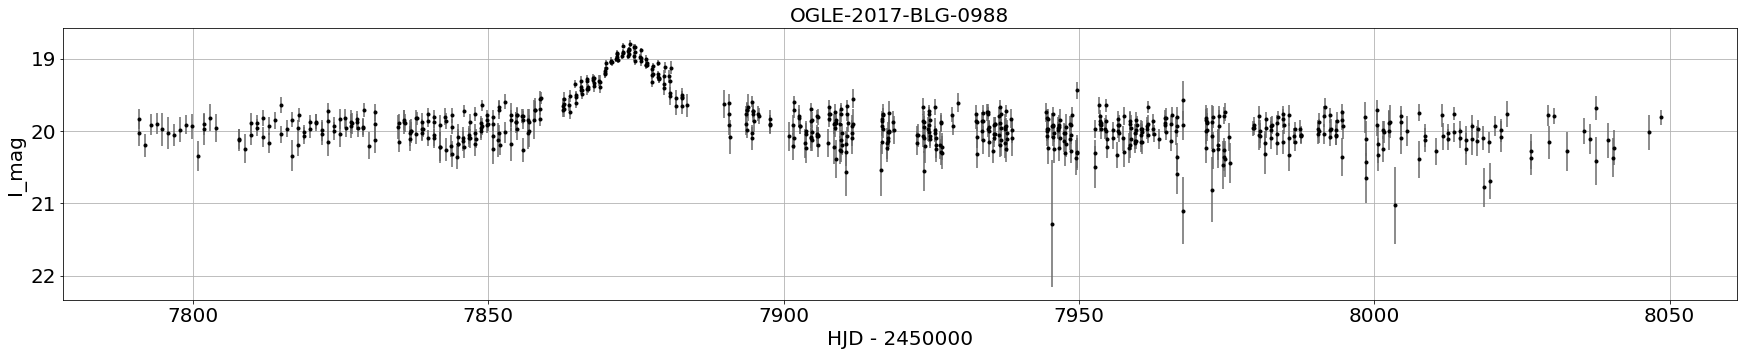

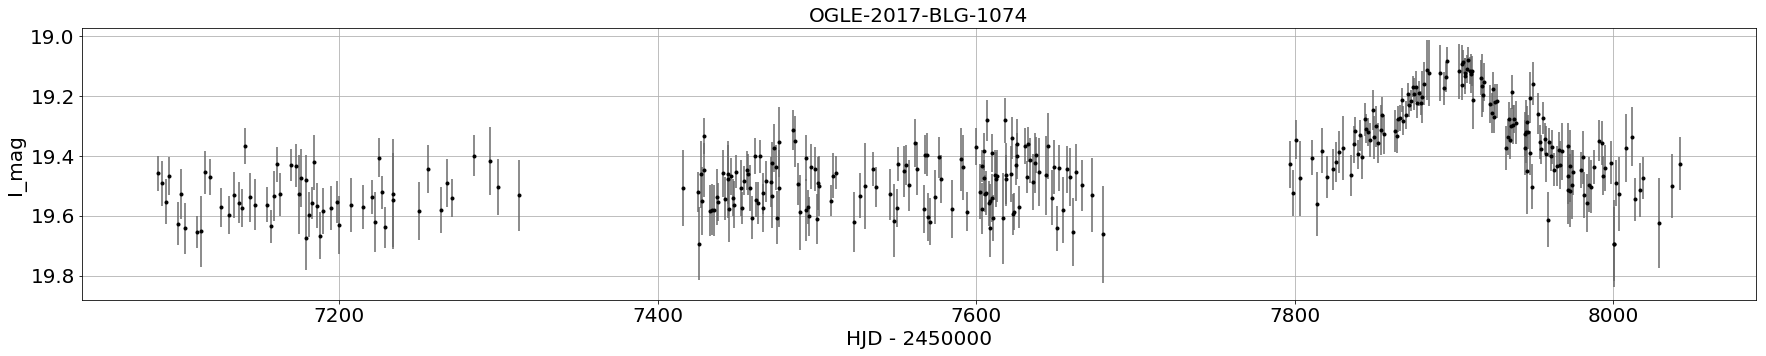

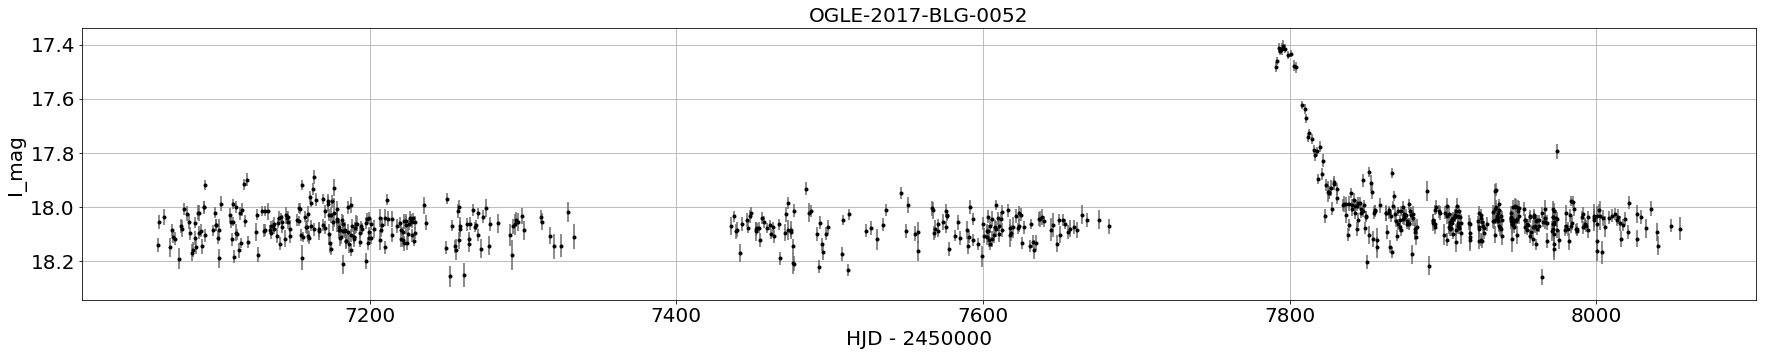

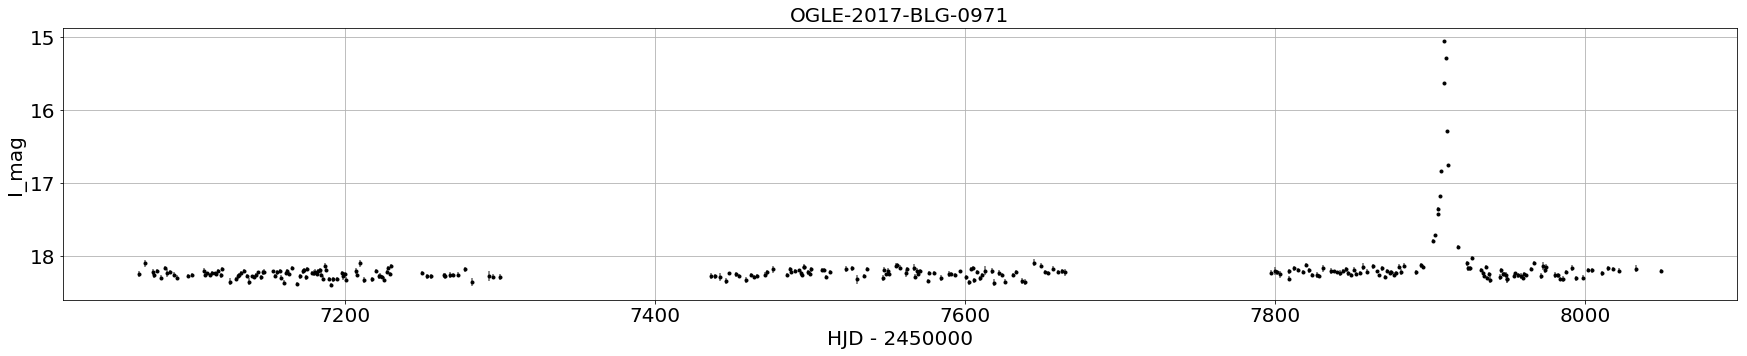

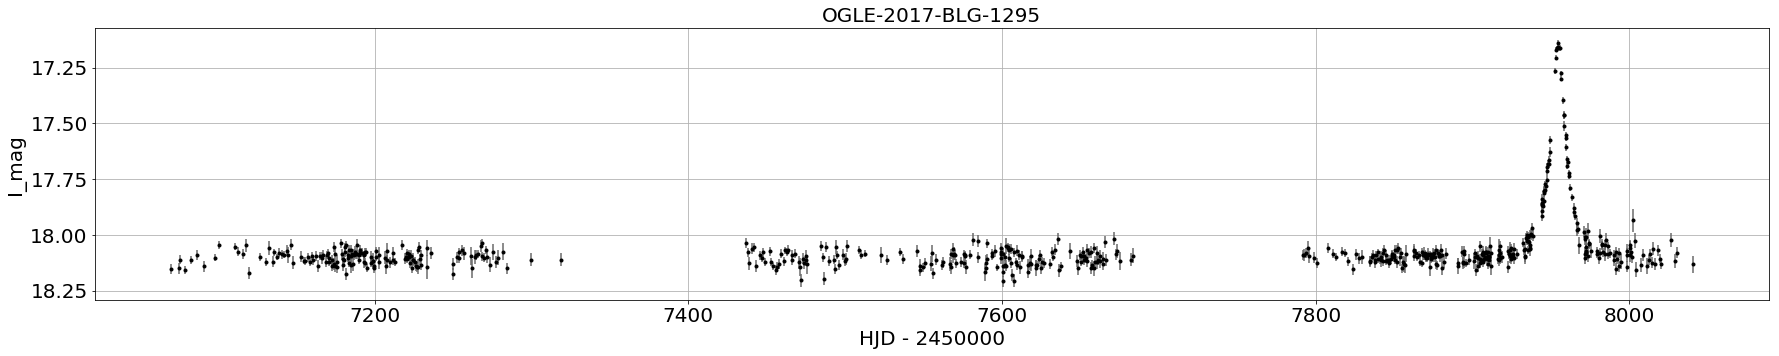

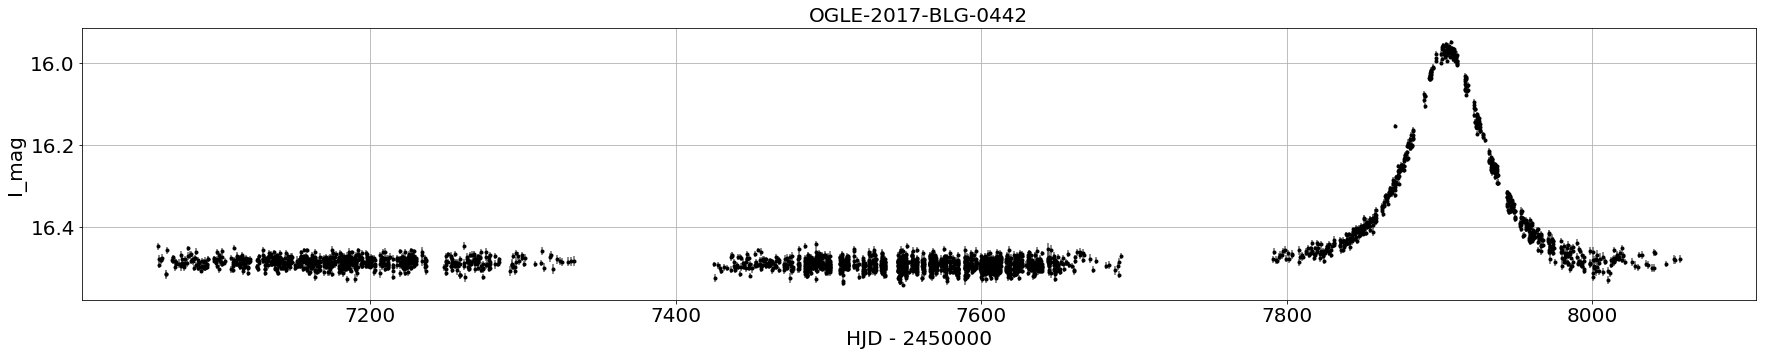

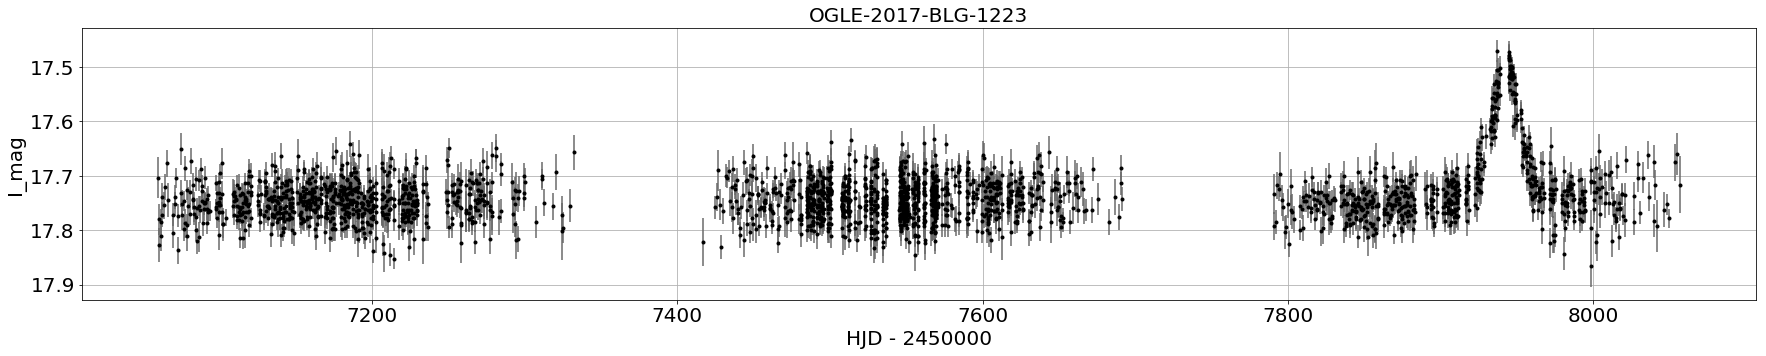

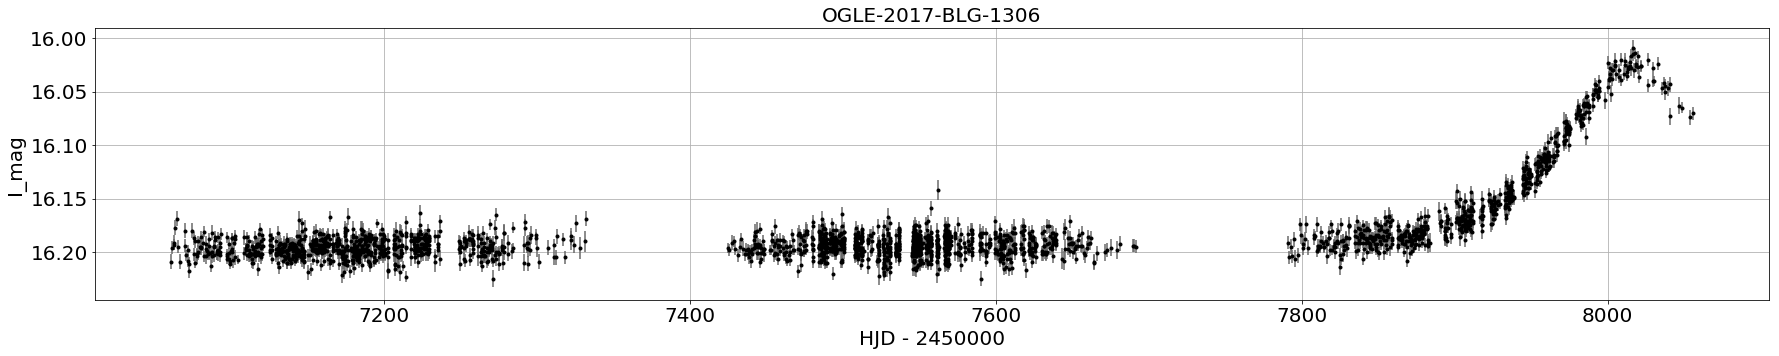

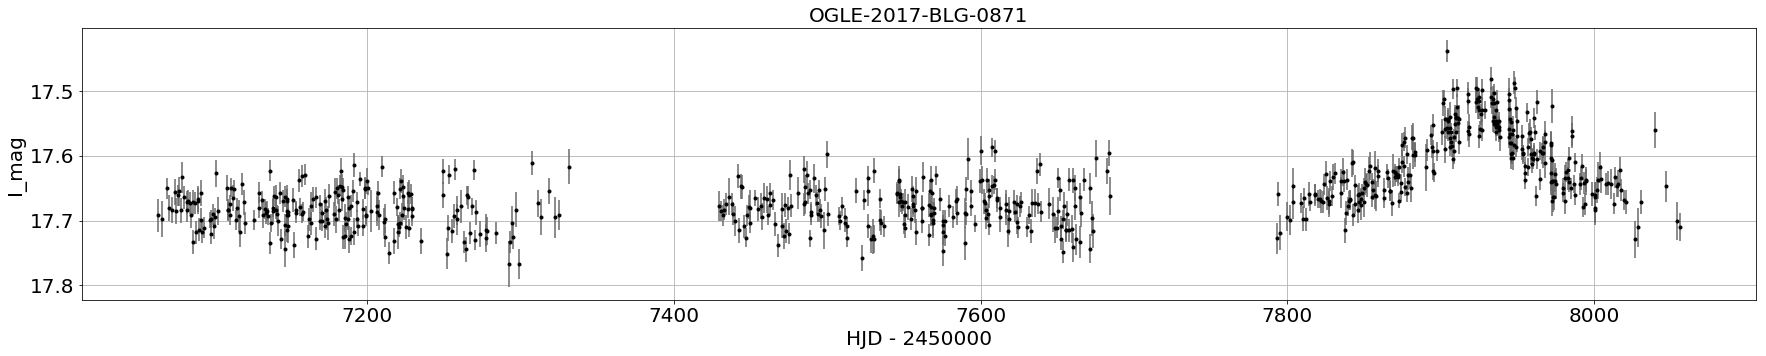

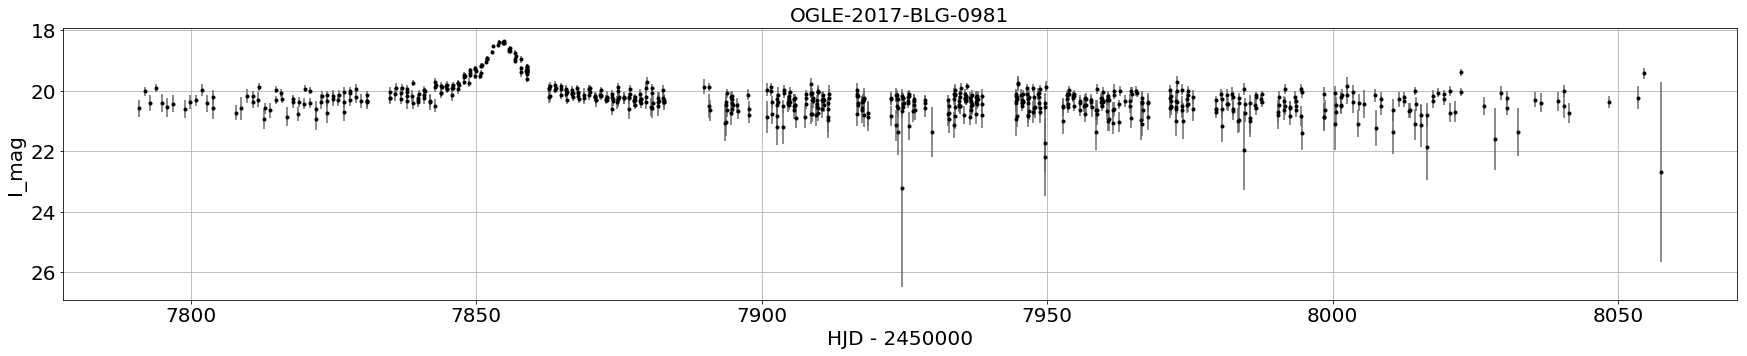

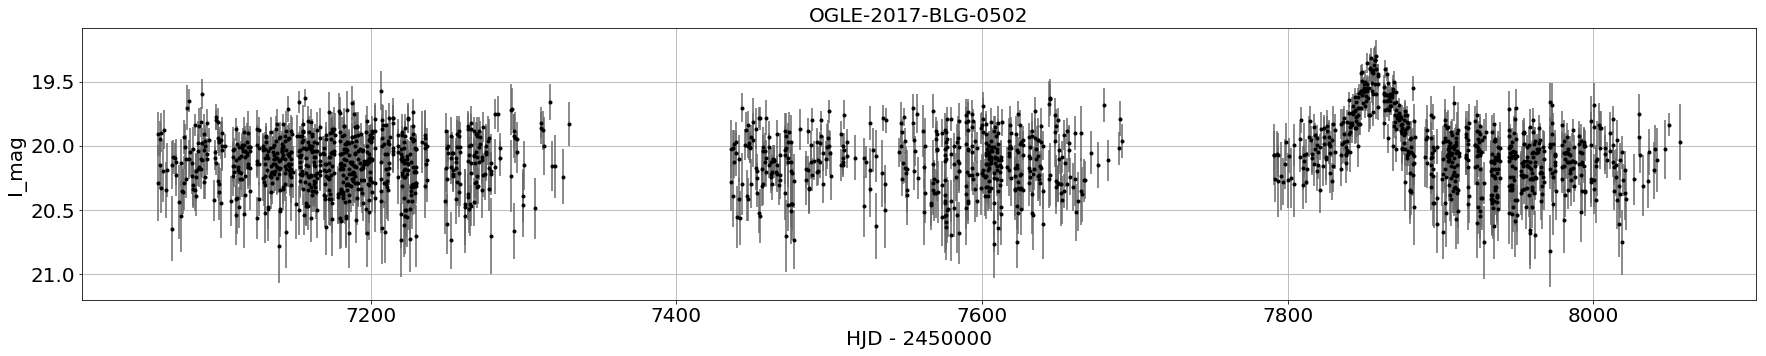

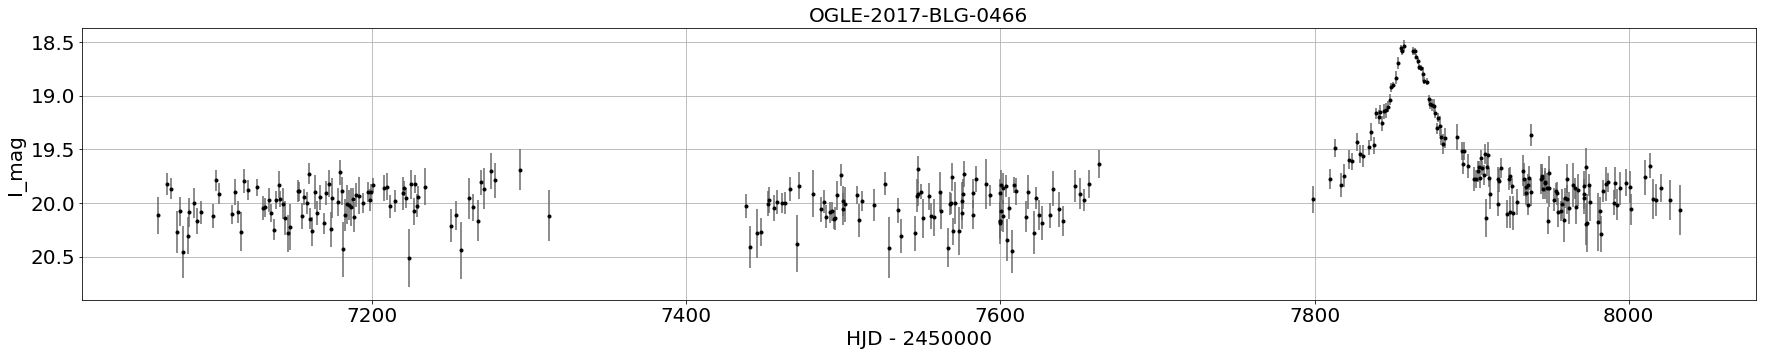

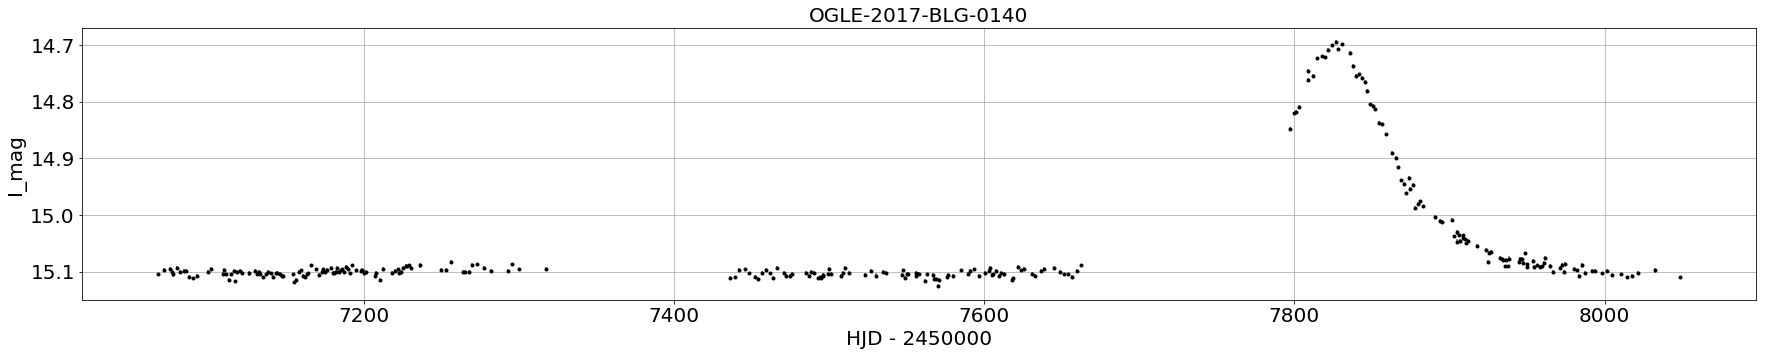

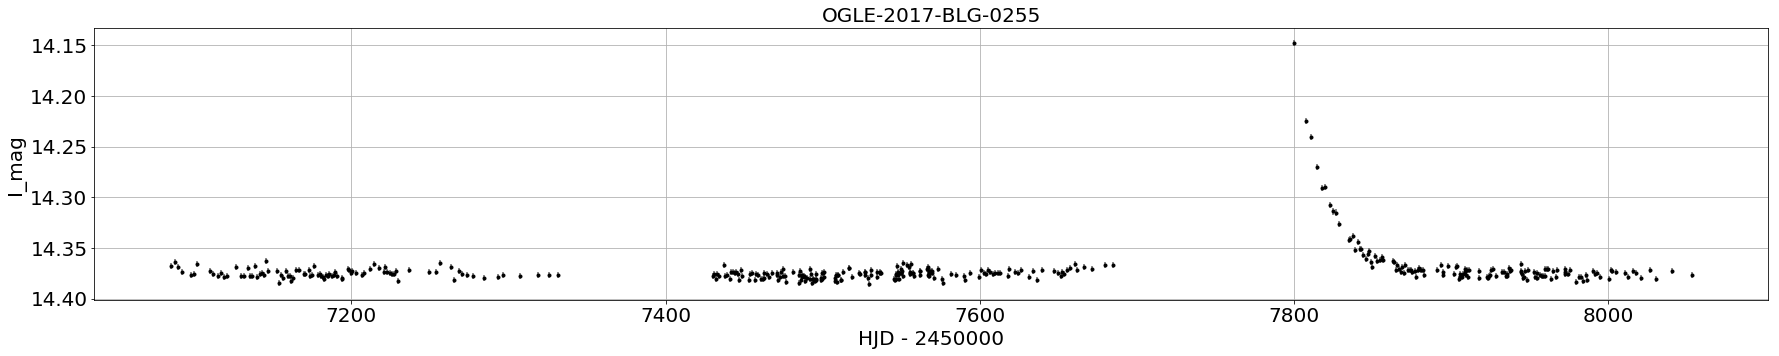

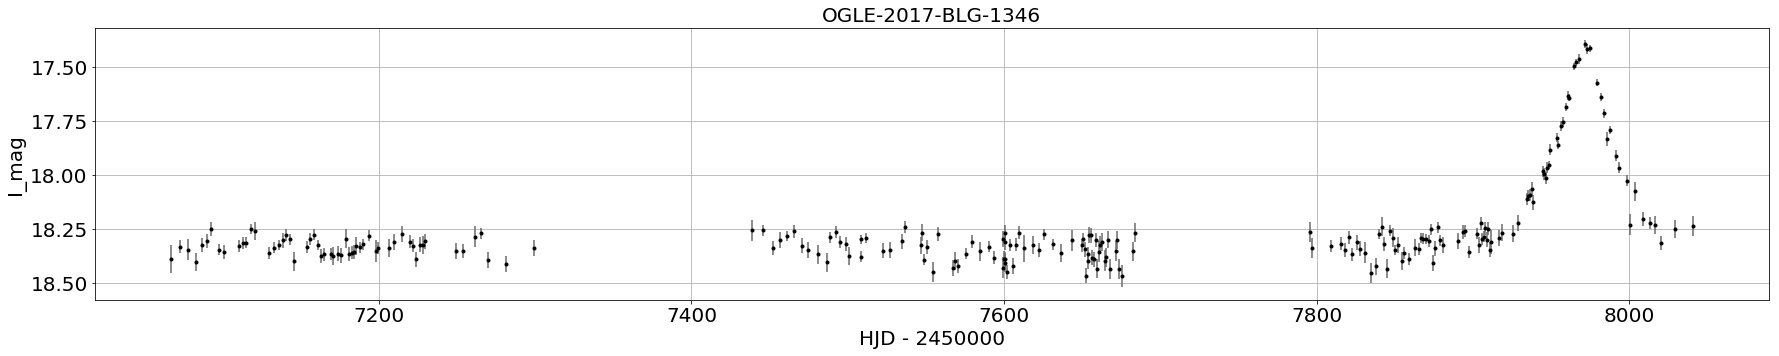

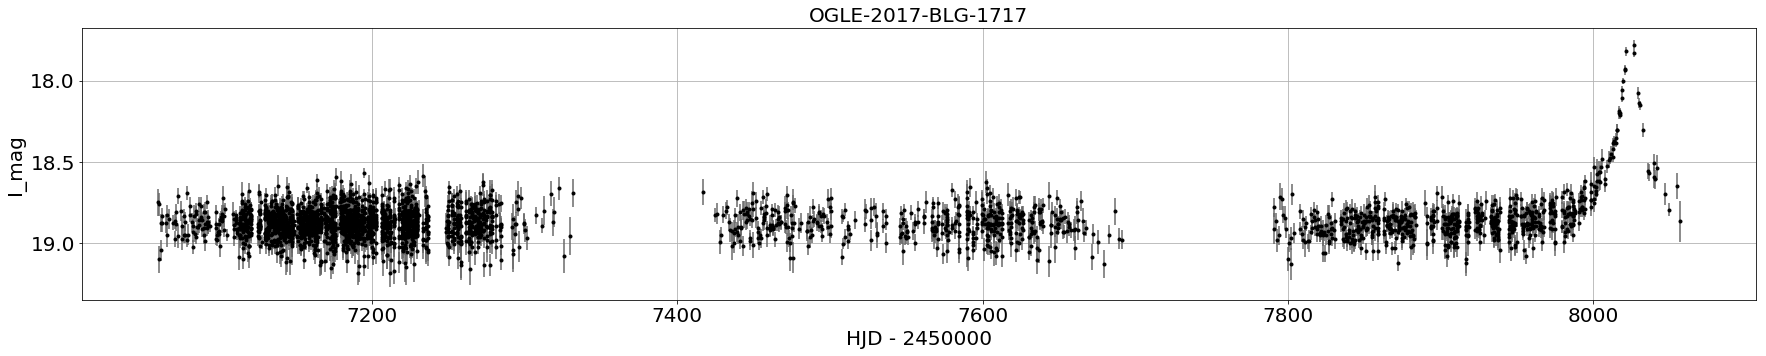

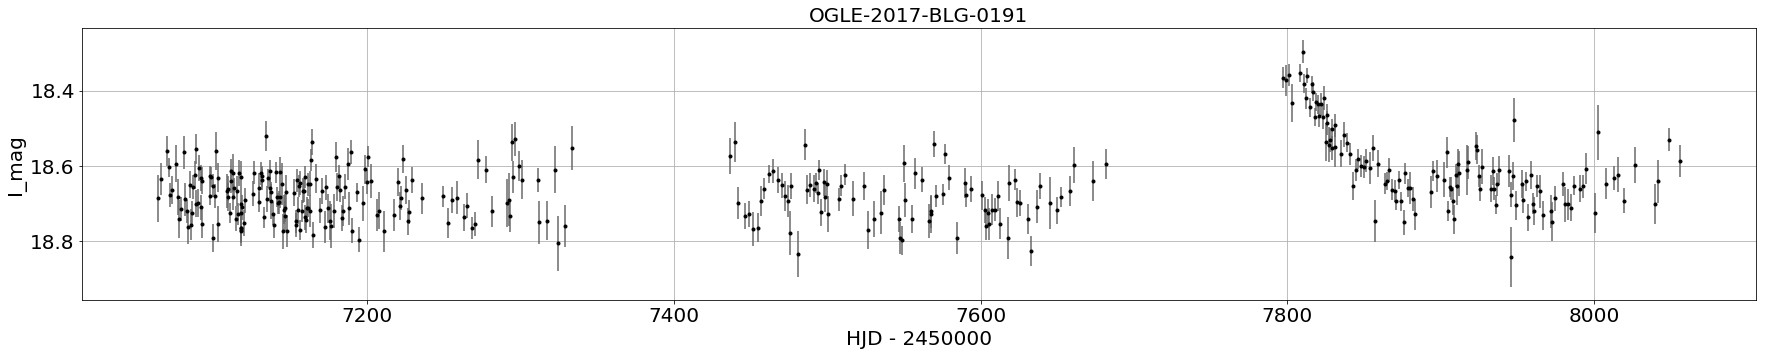

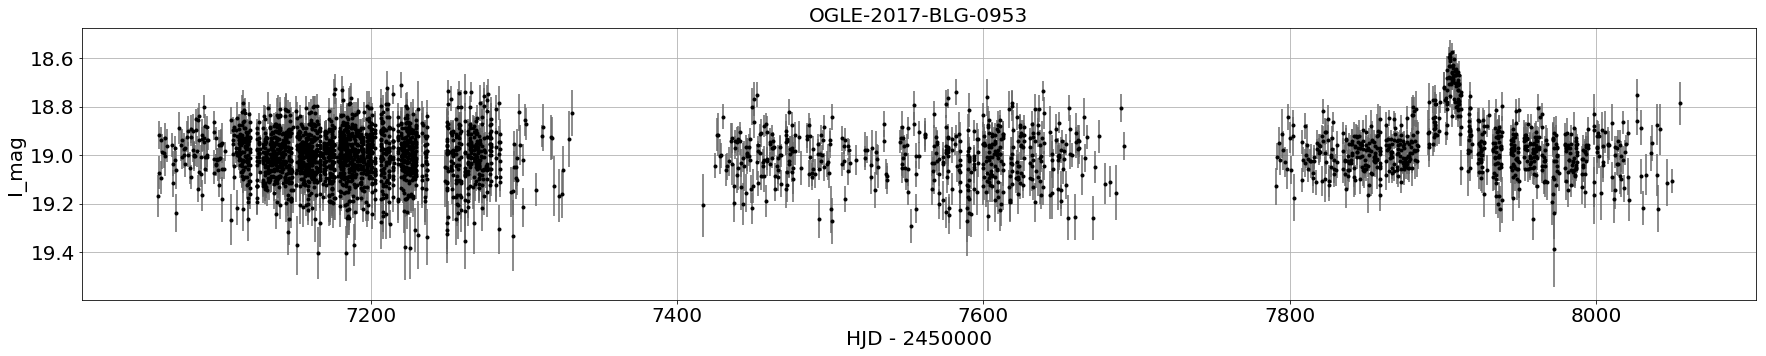

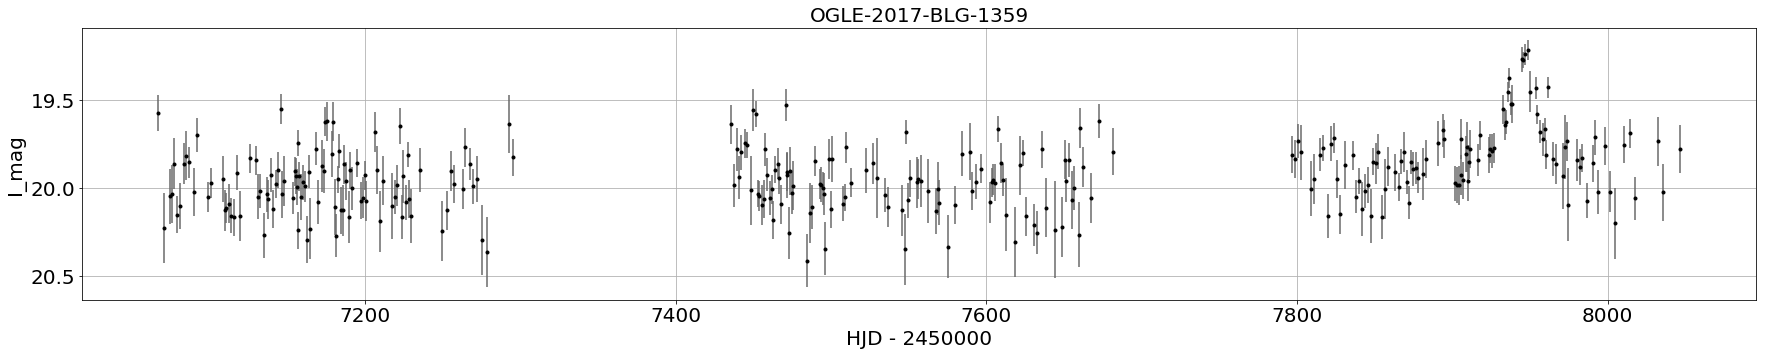

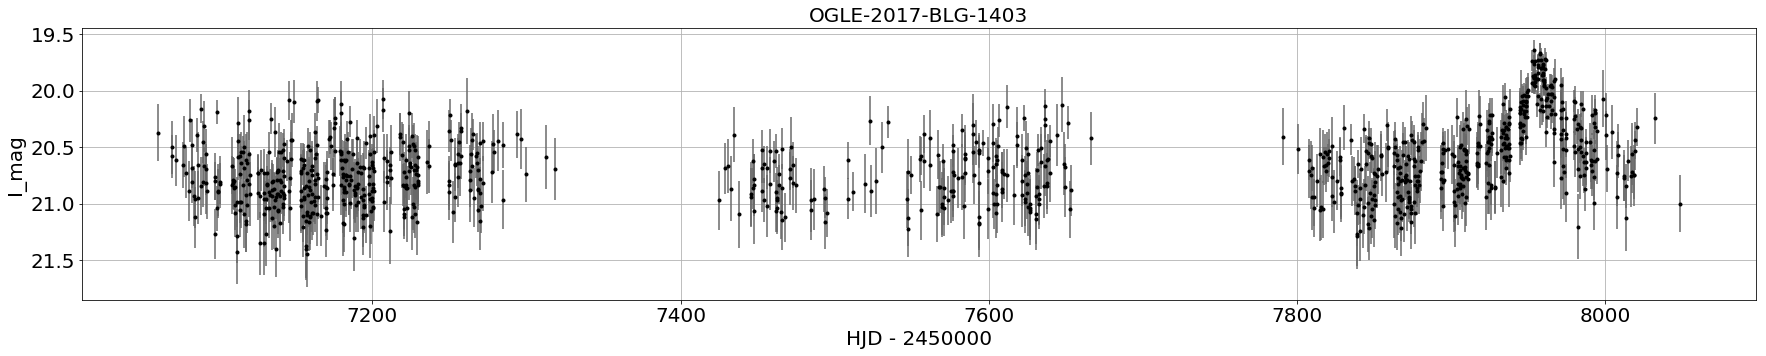

In [2]:
random.seed(34)

events = []  # data for each event

data_path = '/home/fran/data/OGLE_ews/2017/'
dirs = []
for directory in os.listdir(data_path):
    dirs.append(directory)

random.shuffle(dirs)
i = 0
n_events = 80
for directory in dirs:
    if (i < n_events):
        event = OGLEData(data_path + directory)
        events.append(event)
        i = i + 1

event = OGLEData('/home/fran/data/OGLE_ews/2017/blg-1403')
events.append(event) 

# interesting_events=['0037', '0569', '1256']

for event in events:
    fig, ax = plt.subplots(figsize=(30, 5))
    event.plot(ax)

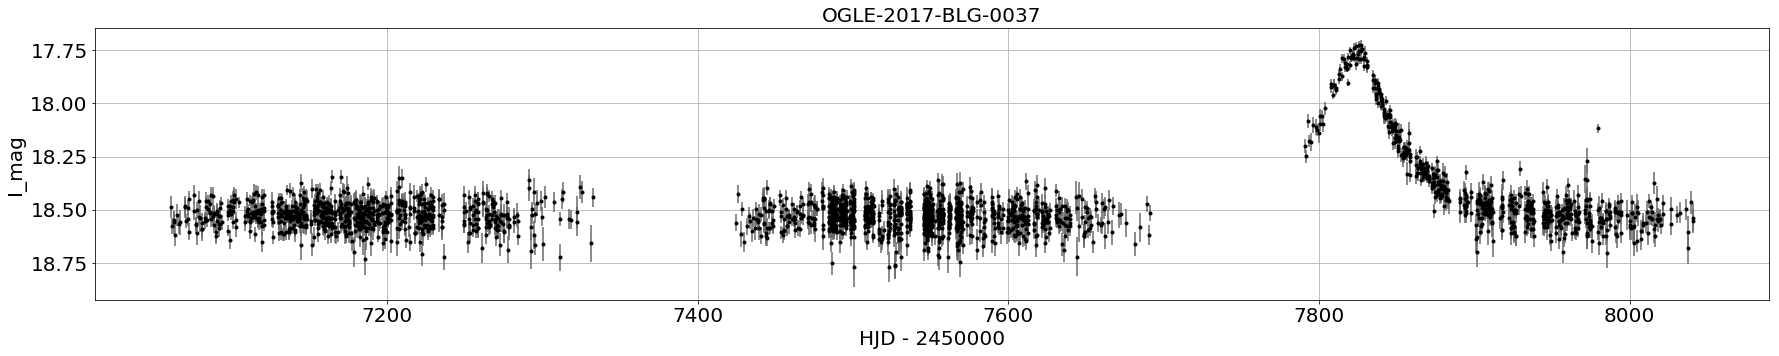

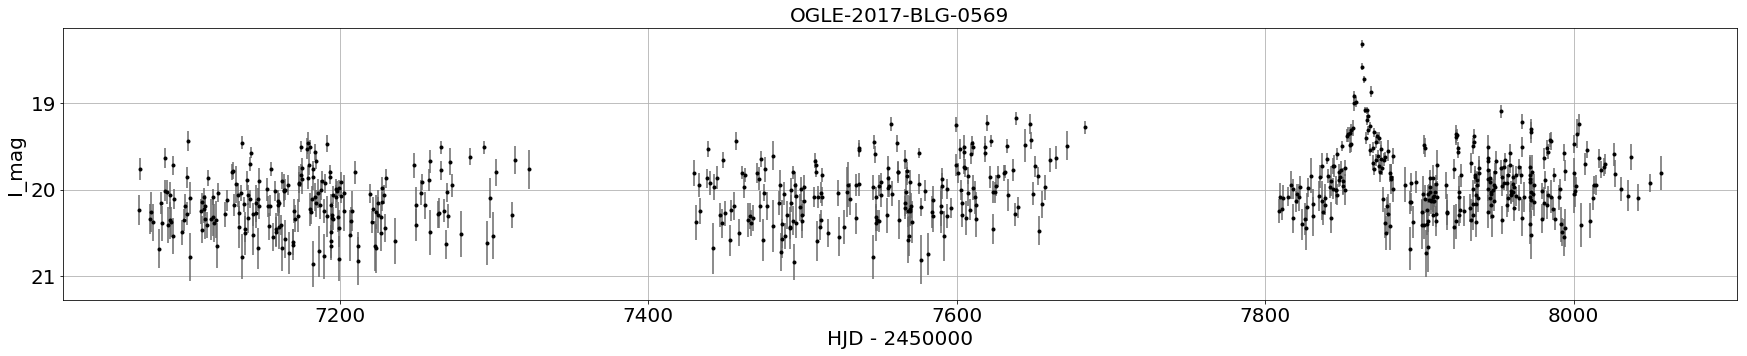

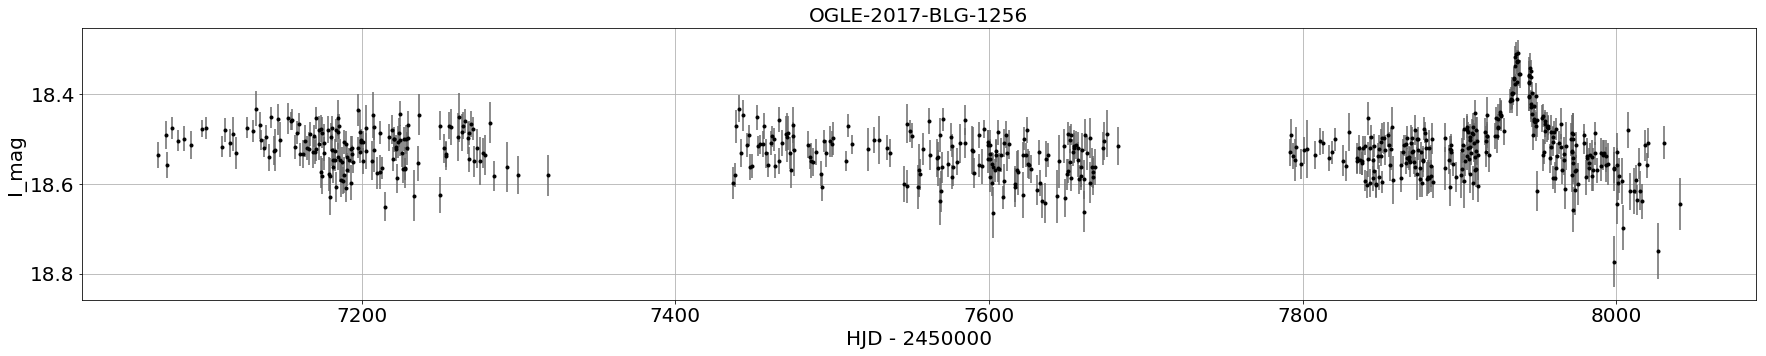

In [3]:
dirs2 = ['0037', '0569', '1256']
events2 = []
for directory in dirs2:
    event2 = OGLEData(data_path + 'blg-' + directory)
    events2.append(event2)

for event in events2:
    fig, ax = plt.subplots(figsize=(30, 5))
    event.plot(ax)

(7069.876279999968, 7400.0, -4.870236473072081, 4.92847235473086)

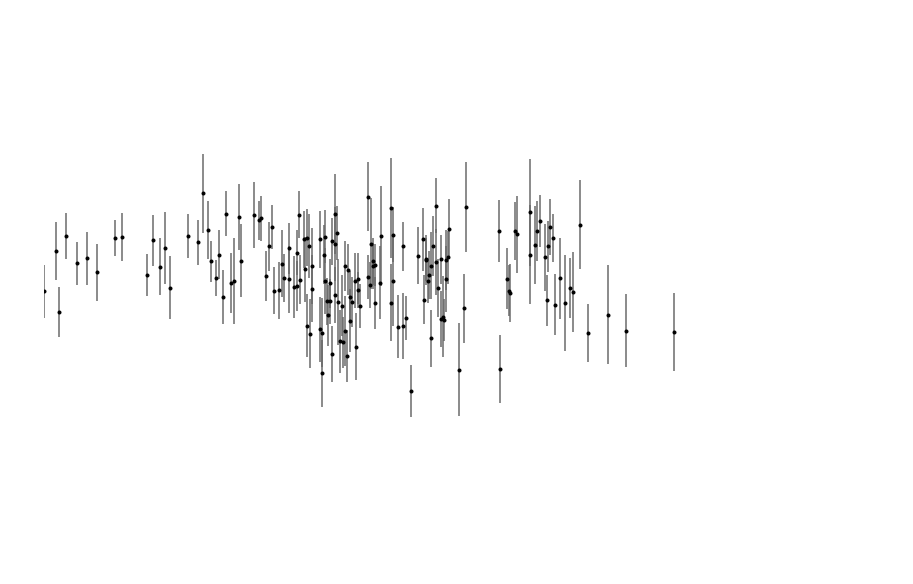

In [4]:
fig, ax = plt.subplots(figsize=(15, 10))

df = events2[2].get_standardized_data()
t = df['HJD - 2450000'].values
F = df['I_flux'].values
F_err = df['I_flux_err'].values

ax.errorbar(t, F, F_err, fmt='.', color='black', label='Data', 
    ecolor='#686868')
ax.set_xlim(t[0], 7400)
ax.axis('off')


(7800.0, 7940.0, -2.0779331564078514, 10.078107011041244)

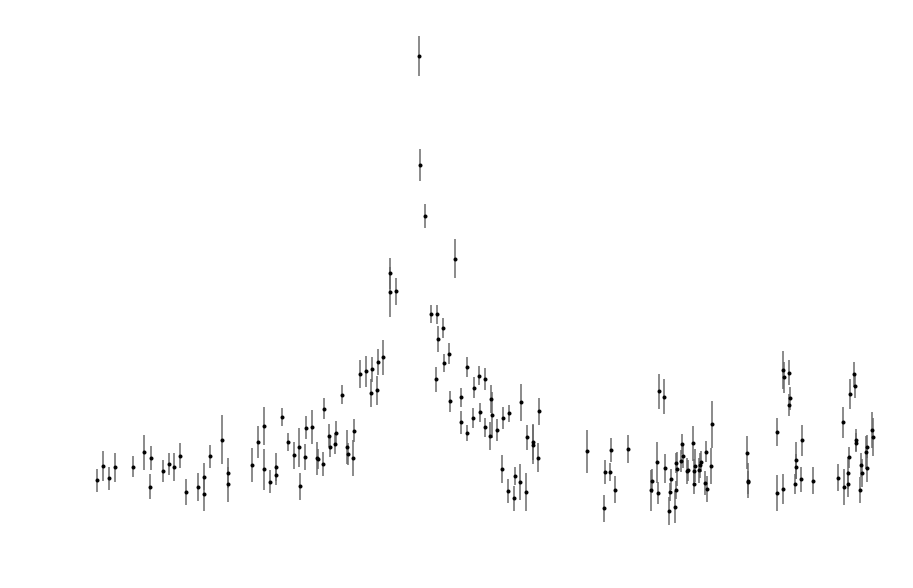

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))

df = events2[1].get_standardized_data()
t = df['HJD - 2450000'].values
F = df['I_flux'].values
F_err = df['I_flux_err'].values

ax.errorbar(t, F, F_err, fmt='.', color='black', label='Data', 
    ecolor='#686868')
ax.set_xlim(7800, 7940)
ax.axis('off')

Text(0, 0.5, '$A(u)$')

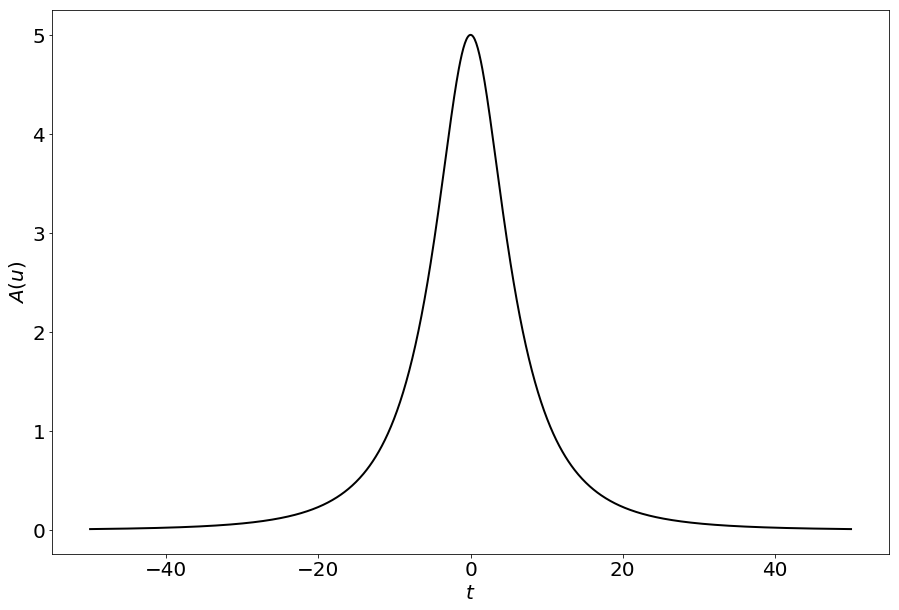

In [6]:
t = np.linspace(-50, 50, 1000)

def pspl(t, DeltaF, Fb, t0, teff, tE):
    u0 = teff/tE
    u = np.sqrt(u0**2 + (t - t0)**2/tE**2)
    A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))
    return DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb

fig, ax = plt.subplots( figsize=(15, 10))

DeltaF_ = 5.
Fb_ = 0.
t0_ = 0.
teff_ = 5.
tE_ = 10.

ax.plot(t, pspl(t, DeltaF_, Fb_, t0_, teff_, tE_), 'k-', lw=2)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$A(u)$')

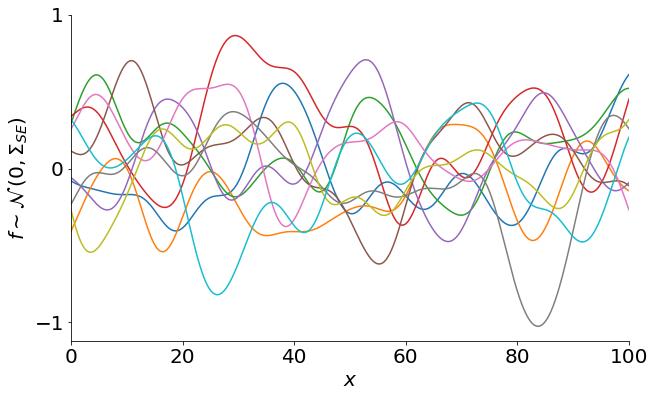

In [111]:
import george
from george import kernels

np.random.seed(42)

gp = george.GP(0.1 * kernels.ExpSquaredKernel(30))

fig, ax = plt.subplots(figsize=(10,6))
for i in range(10):
    y = gp.sample(t)
    ax.plot(t, y,'C' + str(i))
    
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f\sim\mathcal{N}\,(0,\Sigma_{SE})$')
ax.set_yticks([-1, 0, 1])
ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('draws_se_kernel.png')

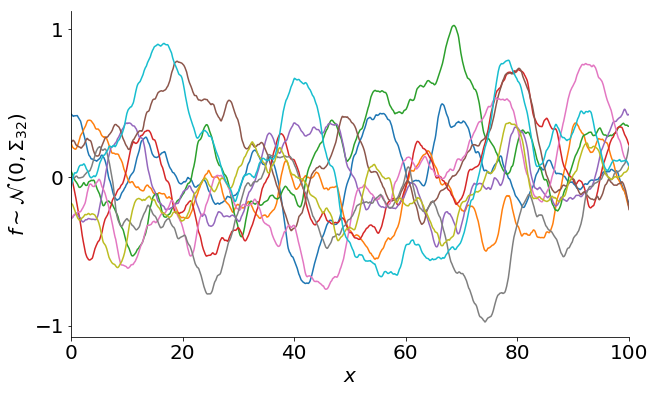

In [117]:
gp = george.GP(0.1 * kernels.Matern32Kernel(30))

fig, ax = plt.subplots(figsize=(10,6))
for i in range(10):
    y = gp.sample(t)
    ax.plot(t, y,'C' + str(i))
    
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f\sim\mathcal{N}\,(0,\Sigma_{32})$')
ax.set_yticks([-1, 0, 1])
ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('draws_matern32.png')

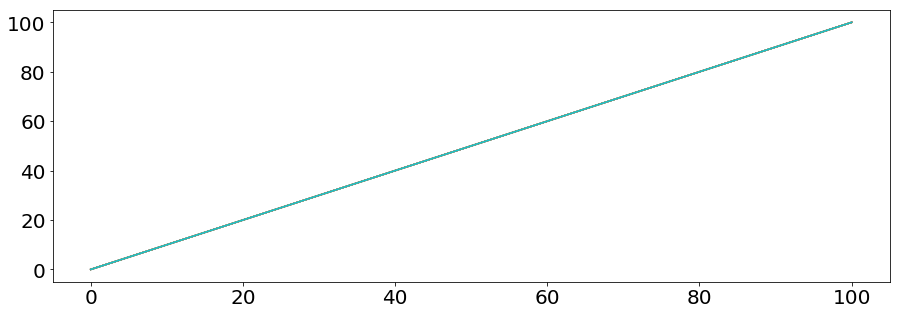

In [71]:
import celerite
from celerite import terms

kernel = terms.SHOTerm(log_S0=np.log(1), log_Q=np.log(1/np.sqrt(2)), log_omega0=np.log(2*np.pi/1.))
gp_celerite = celerite.GP(kernel)
# gp_celerite.compute(t)


fig, ax = plt.subplots(figsize=(15,5))
for i in range(10):
    gp.compute(t)
    mu, cov = gp.predict(t)
    ax.plot(t, mu,'C' + str(i))

1.494196687024391 5.660740814637189


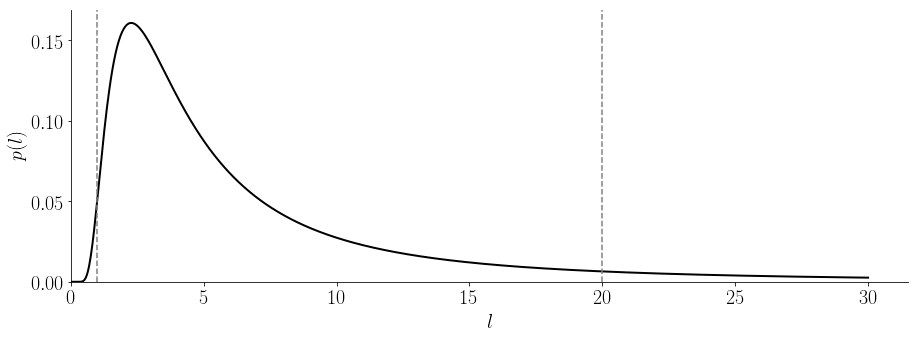

In [25]:
from scipy.stats import invgamma
from scipy.optimize import fsolve

def inverse_gamma_cdf(x, alpha, beta):
    return invgamma.cdf(x, alpha, scale=beta)

def equations_rho(params):
    alpha, beta = params
    return (inverse_gamma_cdf(1., alpha, beta) - 0.01, inverse_gamma_cdf(100., alpha, beta) - 0.99)

alpha, beta =  fsolve(equations_rho, (0.1, 0.1))
print(alpha, beta)

# Plot inverse gamma distribution with those parameters
fig, ax = plt.subplots(figsize=(15, 5))

x = np.linspace(0, 30, 1000)
ax.plot(x, invgamma.pdf(x, alpha, scale=beta), lw=2, color='black')
# ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$p(l)$')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.axvline(1, color='gray',linestyle='dashed')
ax.axvline(20, color='gray',linestyle='dashed')
plt.savefig('invgamma_prior.png')